# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

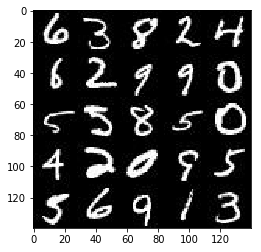

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

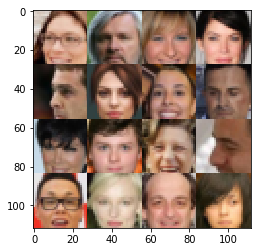

In [4]:
show_n_images = 20



"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_images = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_images')
    z = tf.placeholder(tf.float32, (None, z_dim), name='z')
    learning_rate = tf.placeholder(tf.float32, (None))

    return inputs_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
           
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        relu1 = tf.layers.dropout(relu1,rate=0.5) 
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2,rate=0.5) 
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3,rate=0.5) 
        
        x4 = tf.layers.conv2d(relu3, 512, 4, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        relu4 = tf.layers.dropout(relu4,rate=0.5) 

        # Flatten it
        flat = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1,rate=0.5) 
        
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2,rate=0.5) 
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3,rate=0.5) 
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 4, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.layers.dropout(x4,rate=0.5) 
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
      
        
        out = tf.tanh(logits)
        
        return out

            
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.9
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, learn_r = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_r, beta1)
    step = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
              
                step = step+1
                                                        
                # scale to be between -1 and +1 
                X_std = (batch_images - np.amin(batch_images))/(np.amax(batch_images)-np.amin(batch_images))
                
                
                batch_images =  (X_std * 2) - 1
                
                
                 
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learn_r:learning_rate})
                # flip lables :
                
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images,learn_r:learning_rate})
                
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({inputs_z:batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z:batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, step),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g), "  difference (D-G): {:.4f}".format(train_loss_d-train_loss_g) )

                if step % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

                    
               
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 10... Discriminator Loss: 0.5220... Generator Loss: 10.7734   difference (D-G): -10.2513
Epoch 1/2 Step 20... Discriminator Loss: 0.6868... Generator Loss: 5.1051   difference (D-G): -4.4183
Epoch 1/2 Step 30... Discriminator Loss: 0.5175... Generator Loss: 2.9720   difference (D-G): -2.4545
Epoch 1/2 Step 40... Discriminator Loss: 0.3823... Generator Loss: 7.7609   difference (D-G): -7.3786
Epoch 1/2 Step 50... Discriminator Loss: 0.3750... Generator Loss: 6.3644   difference (D-G): -5.9894
Epoch 1/2 Step 60... Discriminator Loss: 0.5724... Generator Loss: 1.6779   difference (D-G): -1.1055
Epoch 1/2 Step 70... Discriminator Loss: 0.3716... Generator Loss: 4.2095   difference (D-G): -3.8379
Epoch 1/2 Step 80... Discriminator Loss: 1.3585... Generator Loss: 5.0237   difference (D-G): -3.6653
Epoch 1/2 Step 90... Discriminator Loss: 1.4860... Generator Loss: 9.0418   difference (D-G): -7.5558
Epoch 1/2 Step 100... Discriminator Loss: 1.0784... Generator Loss: 0.9152   dif

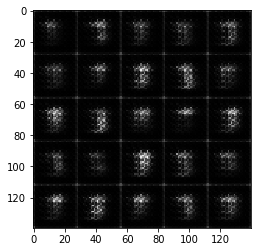

Epoch 1/2 Step 110... Discriminator Loss: 1.6987... Generator Loss: 0.3293   difference (D-G): 1.3694
Epoch 1/2 Step 120... Discriminator Loss: 1.2707... Generator Loss: 7.9635   difference (D-G): -6.6927
Epoch 1/2 Step 130... Discriminator Loss: 1.0497... Generator Loss: 0.9875   difference (D-G): 0.0622
Epoch 1/2 Step 140... Discriminator Loss: 0.3584... Generator Loss: 5.6761   difference (D-G): -5.3177
Epoch 1/2 Step 150... Discriminator Loss: 0.9443... Generator Loss: 0.8226   difference (D-G): 0.1217
Epoch 1/2 Step 160... Discriminator Loss: 1.5897... Generator Loss: 0.6787   difference (D-G): 0.9110
Epoch 1/2 Step 170... Discriminator Loss: 1.1990... Generator Loss: 2.9716   difference (D-G): -1.7726
Epoch 1/2 Step 180... Discriminator Loss: 1.2247... Generator Loss: 3.6831   difference (D-G): -2.4584
Epoch 1/2 Step 190... Discriminator Loss: 1.4506... Generator Loss: 0.5238   difference (D-G): 0.9268
Epoch 1/2 Step 200... Discriminator Loss: 1.0957... Generator Loss: 1.4380   d

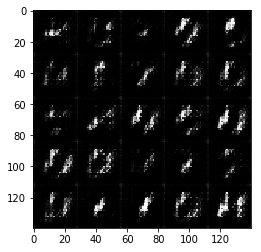

Epoch 1/2 Step 210... Discriminator Loss: 0.8794... Generator Loss: 1.9135   difference (D-G): -1.0342
Epoch 1/2 Step 220... Discriminator Loss: 1.0072... Generator Loss: 2.7510   difference (D-G): -1.7438
Epoch 1/2 Step 230... Discriminator Loss: 0.6312... Generator Loss: 1.7486   difference (D-G): -1.1174
Epoch 1/2 Step 240... Discriminator Loss: 1.7598... Generator Loss: 0.3634   difference (D-G): 1.3964
Epoch 1/2 Step 250... Discriminator Loss: 1.6492... Generator Loss: 0.4182   difference (D-G): 1.2311
Epoch 1/2 Step 260... Discriminator Loss: 1.1561... Generator Loss: 1.1777   difference (D-G): -0.0216
Epoch 1/2 Step 270... Discriminator Loss: 0.6559... Generator Loss: 2.6956   difference (D-G): -2.0398
Epoch 1/2 Step 280... Discriminator Loss: 1.6839... Generator Loss: 0.4632   difference (D-G): 1.2207
Epoch 1/2 Step 290... Discriminator Loss: 0.9524... Generator Loss: 2.4645   difference (D-G): -1.5122
Epoch 1/2 Step 300... Discriminator Loss: 1.3469... Generator Loss: 0.6063  

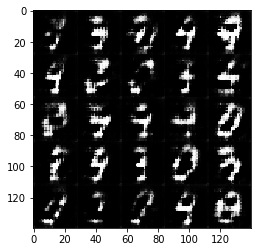

Epoch 1/2 Step 310... Discriminator Loss: 1.0169... Generator Loss: 1.5990   difference (D-G): -0.5821
Epoch 1/2 Step 320... Discriminator Loss: 1.1107... Generator Loss: 0.7301   difference (D-G): 0.3806
Epoch 1/2 Step 330... Discriminator Loss: 1.5656... Generator Loss: 2.3560   difference (D-G): -0.7903
Epoch 1/2 Step 340... Discriminator Loss: 0.9500... Generator Loss: 1.0522   difference (D-G): -0.1022
Epoch 1/2 Step 350... Discriminator Loss: 1.4964... Generator Loss: 0.4670   difference (D-G): 1.0295
Epoch 1/2 Step 360... Discriminator Loss: 1.7899... Generator Loss: 0.3016   difference (D-G): 1.4883
Epoch 1/2 Step 370... Discriminator Loss: 0.8315... Generator Loss: 1.9139   difference (D-G): -1.0824
Epoch 1/2 Step 380... Discriminator Loss: 0.6319... Generator Loss: 1.6177   difference (D-G): -0.9859
Epoch 1/2 Step 390... Discriminator Loss: 0.8918... Generator Loss: 1.4800   difference (D-G): -0.5882
Epoch 1/2 Step 400... Discriminator Loss: 0.8223... Generator Loss: 1.1696  

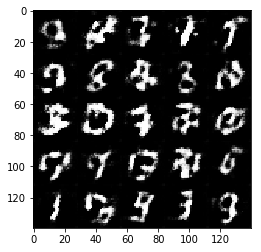

Epoch 1/2 Step 410... Discriminator Loss: 1.4338... Generator Loss: 0.7847   difference (D-G): 0.6491
Epoch 1/2 Step 420... Discriminator Loss: 0.9874... Generator Loss: 1.9251   difference (D-G): -0.9378
Epoch 1/2 Step 430... Discriminator Loss: 1.4668... Generator Loss: 3.5059   difference (D-G): -2.0391
Epoch 1/2 Step 440... Discriminator Loss: 0.9337... Generator Loss: 1.1741   difference (D-G): -0.2404
Epoch 1/2 Step 450... Discriminator Loss: 0.9923... Generator Loss: 1.5179   difference (D-G): -0.5256
Epoch 1/2 Step 460... Discriminator Loss: 1.0344... Generator Loss: 0.7529   difference (D-G): 0.2815
Epoch 1/2 Step 470... Discriminator Loss: 1.6168... Generator Loss: 0.3687   difference (D-G): 1.2481
Epoch 1/2 Step 480... Discriminator Loss: 0.7477... Generator Loss: 1.2216   difference (D-G): -0.4739
Epoch 1/2 Step 490... Discriminator Loss: 1.1764... Generator Loss: 2.6601   difference (D-G): -1.4837
Epoch 1/2 Step 500... Discriminator Loss: 1.8235... Generator Loss: 0.3099  

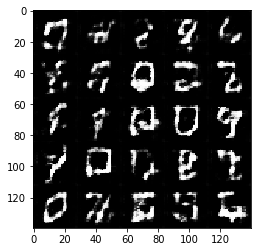

Epoch 1/2 Step 510... Discriminator Loss: 1.3370... Generator Loss: 0.5264   difference (D-G): 0.8106
Epoch 1/2 Step 520... Discriminator Loss: 1.4663... Generator Loss: 3.4436   difference (D-G): -1.9773
Epoch 1/2 Step 530... Discriminator Loss: 1.1713... Generator Loss: 0.8124   difference (D-G): 0.3588
Epoch 1/2 Step 540... Discriminator Loss: 1.3022... Generator Loss: 0.5760   difference (D-G): 0.7262
Epoch 1/2 Step 550... Discriminator Loss: 0.8838... Generator Loss: 1.4382   difference (D-G): -0.5544
Epoch 1/2 Step 560... Discriminator Loss: 1.4615... Generator Loss: 0.4269   difference (D-G): 1.0346
Epoch 1/2 Step 570... Discriminator Loss: 0.7818... Generator Loss: 1.5954   difference (D-G): -0.8136
Epoch 1/2 Step 580... Discriminator Loss: 1.3534... Generator Loss: 3.0502   difference (D-G): -1.6969
Epoch 1/2 Step 590... Discriminator Loss: 1.1625... Generator Loss: 0.6512   difference (D-G): 0.5113
Epoch 1/2 Step 600... Discriminator Loss: 0.7266... Generator Loss: 2.8310   d

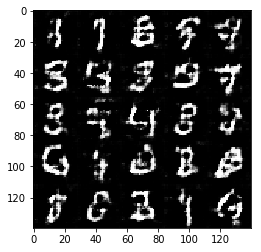

Epoch 1/2 Step 610... Discriminator Loss: 2.3702... Generator Loss: 0.1833   difference (D-G): 2.1870
Epoch 1/2 Step 620... Discriminator Loss: 0.9313... Generator Loss: 0.9712   difference (D-G): -0.0399
Epoch 1/2 Step 630... Discriminator Loss: 1.3968... Generator Loss: 0.5385   difference (D-G): 0.8583
Epoch 1/2 Step 640... Discriminator Loss: 0.9499... Generator Loss: 0.9910   difference (D-G): -0.0411
Epoch 1/2 Step 650... Discriminator Loss: 0.9271... Generator Loss: 1.1875   difference (D-G): -0.2605
Epoch 1/2 Step 660... Discriminator Loss: 1.1668... Generator Loss: 2.7067   difference (D-G): -1.5398
Epoch 1/2 Step 670... Discriminator Loss: 1.2341... Generator Loss: 0.5994   difference (D-G): 0.6347
Epoch 1/2 Step 680... Discriminator Loss: 1.9356... Generator Loss: 0.2845   difference (D-G): 1.6511
Epoch 1/2 Step 690... Discriminator Loss: 0.8433... Generator Loss: 1.2450   difference (D-G): -0.4018
Epoch 1/2 Step 700... Discriminator Loss: 0.7073... Generator Loss: 1.9765   

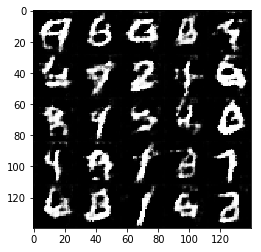

Epoch 1/2 Step 710... Discriminator Loss: 1.1596... Generator Loss: 0.6947   difference (D-G): 0.4649
Epoch 1/2 Step 720... Discriminator Loss: 1.2337... Generator Loss: 0.5625   difference (D-G): 0.6712
Epoch 1/2 Step 730... Discriminator Loss: 1.2070... Generator Loss: 0.6170   difference (D-G): 0.5900
Epoch 1/2 Step 740... Discriminator Loss: 2.3927... Generator Loss: 3.4700   difference (D-G): -1.0772
Epoch 1/2 Step 750... Discriminator Loss: 1.2692... Generator Loss: 0.6618   difference (D-G): 0.6074
Epoch 1/2 Step 760... Discriminator Loss: 0.9800... Generator Loss: 0.8247   difference (D-G): 0.1553
Epoch 1/2 Step 770... Discriminator Loss: 1.1028... Generator Loss: 0.7706   difference (D-G): 0.3323
Epoch 1/2 Step 780... Discriminator Loss: 2.0286... Generator Loss: 0.2427   difference (D-G): 1.7859
Epoch 1/2 Step 790... Discriminator Loss: 1.8153... Generator Loss: 0.2849   difference (D-G): 1.5304
Epoch 1/2 Step 800... Discriminator Loss: 0.9324... Generator Loss: 1.1146   diff

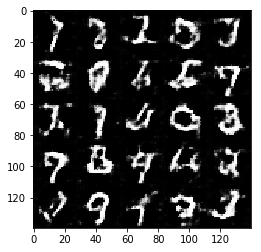

Epoch 1/2 Step 810... Discriminator Loss: 2.1404... Generator Loss: 0.3166   difference (D-G): 1.8238
Epoch 1/2 Step 820... Discriminator Loss: 0.8219... Generator Loss: 1.5203   difference (D-G): -0.6984
Epoch 1/2 Step 830... Discriminator Loss: 1.9942... Generator Loss: 0.2653   difference (D-G): 1.7289
Epoch 1/2 Step 840... Discriminator Loss: 1.0459... Generator Loss: 0.7301   difference (D-G): 0.3159
Epoch 1/2 Step 850... Discriminator Loss: 1.7204... Generator Loss: 0.3348   difference (D-G): 1.3855
Epoch 1/2 Step 860... Discriminator Loss: 2.2610... Generator Loss: 0.2018   difference (D-G): 2.0592
Epoch 1/2 Step 870... Discriminator Loss: 1.0798... Generator Loss: 0.7527   difference (D-G): 0.3271
Epoch 1/2 Step 880... Discriminator Loss: 1.1366... Generator Loss: 0.6623   difference (D-G): 0.4743
Epoch 1/2 Step 890... Discriminator Loss: 1.8169... Generator Loss: 0.3720   difference (D-G): 1.4449
Epoch 1/2 Step 900... Discriminator Loss: 0.8628... Generator Loss: 1.1985   diff

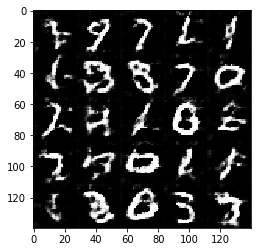

Epoch 1/2 Step 910... Discriminator Loss: 0.7209... Generator Loss: 2.5745   difference (D-G): -1.8536
Epoch 1/2 Step 920... Discriminator Loss: 1.1962... Generator Loss: 0.6640   difference (D-G): 0.5322
Epoch 1/2 Step 930... Discriminator Loss: 1.1903... Generator Loss: 0.7268   difference (D-G): 0.4635
Epoch 1/2 Step 940... Discriminator Loss: 1.2854... Generator Loss: 0.6318   difference (D-G): 0.6536
Epoch 1/2 Step 950... Discriminator Loss: 0.7709... Generator Loss: 1.2455   difference (D-G): -0.4745
Epoch 1/2 Step 960... Discriminator Loss: 0.9934... Generator Loss: 0.9207   difference (D-G): 0.0728
Epoch 1/2 Step 970... Discriminator Loss: 0.8128... Generator Loss: 2.4743   difference (D-G): -1.6615
Epoch 1/2 Step 980... Discriminator Loss: 1.5957... Generator Loss: 0.4161   difference (D-G): 1.1796
Epoch 1/2 Step 990... Discriminator Loss: 0.8413... Generator Loss: 1.0924   difference (D-G): -0.2511
Epoch 1/2 Step 1000... Discriminator Loss: 0.9243... Generator Loss: 1.0263   

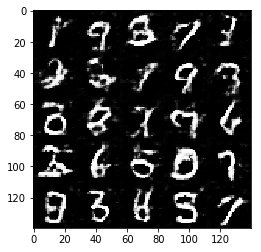

Epoch 1/2 Step 1010... Discriminator Loss: 3.0301... Generator Loss: 0.1056   difference (D-G): 2.9245
Epoch 1/2 Step 1020... Discriminator Loss: 0.6846... Generator Loss: 1.7158   difference (D-G): -1.0312
Epoch 1/2 Step 1030... Discriminator Loss: 0.9576... Generator Loss: 3.2589   difference (D-G): -2.3013
Epoch 1/2 Step 1040... Discriminator Loss: 0.7639... Generator Loss: 2.4318   difference (D-G): -1.6679
Epoch 1/2 Step 1050... Discriminator Loss: 0.8958... Generator Loss: 0.9960   difference (D-G): -0.1002
Epoch 1/2 Step 1060... Discriminator Loss: 1.2999... Generator Loss: 0.5241   difference (D-G): 0.7759
Epoch 1/2 Step 1070... Discriminator Loss: 1.0408... Generator Loss: 0.9241   difference (D-G): 0.1168
Epoch 1/2 Step 1080... Discriminator Loss: 1.8882... Generator Loss: 0.3572   difference (D-G): 1.5311
Epoch 1/2 Step 1090... Discriminator Loss: 0.9337... Generator Loss: 0.9865   difference (D-G): -0.0528
Epoch 1/2 Step 1100... Discriminator Loss: 1.0549... Generator Loss:

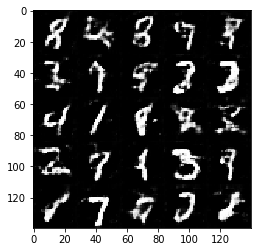

Epoch 1/2 Step 1110... Discriminator Loss: 0.9191... Generator Loss: 1.0011   difference (D-G): -0.0819
Epoch 1/2 Step 1120... Discriminator Loss: 1.3950... Generator Loss: 3.6921   difference (D-G): -2.2971
Epoch 1/2 Step 1130... Discriminator Loss: 0.9179... Generator Loss: 0.9421   difference (D-G): -0.0242
Epoch 1/2 Step 1140... Discriminator Loss: 1.4452... Generator Loss: 0.5184   difference (D-G): 0.9268
Epoch 1/2 Step 1150... Discriminator Loss: 2.9262... Generator Loss: 0.0929   difference (D-G): 2.8333
Epoch 1/2 Step 1160... Discriminator Loss: 0.8882... Generator Loss: 1.0885   difference (D-G): -0.2003
Epoch 1/2 Step 1170... Discriminator Loss: 1.9061... Generator Loss: 0.3201   difference (D-G): 1.5861
Epoch 1/2 Step 1180... Discriminator Loss: 1.1000... Generator Loss: 0.7840   difference (D-G): 0.3160
Epoch 1/2 Step 1190... Discriminator Loss: 0.5935... Generator Loss: 2.0496   difference (D-G): -1.4561
Epoch 1/2 Step 1200... Discriminator Loss: 1.4723... Generator Loss:

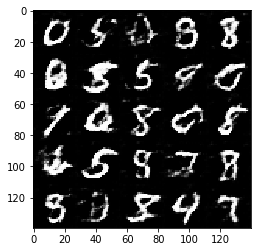

Epoch 1/2 Step 1210... Discriminator Loss: 1.6633... Generator Loss: 0.4781   difference (D-G): 1.1852
Epoch 1/2 Step 1220... Discriminator Loss: 0.6817... Generator Loss: 1.5619   difference (D-G): -0.8803
Epoch 1/2 Step 1230... Discriminator Loss: 1.0044... Generator Loss: 0.7746   difference (D-G): 0.2299
Epoch 1/2 Step 1240... Discriminator Loss: 1.5414... Generator Loss: 0.5162   difference (D-G): 1.0251
Epoch 1/2 Step 1250... Discriminator Loss: 0.7896... Generator Loss: 1.3316   difference (D-G): -0.5421
Epoch 1/2 Step 1260... Discriminator Loss: 1.4790... Generator Loss: 0.4392   difference (D-G): 1.0398
Epoch 1/2 Step 1270... Discriminator Loss: 0.8557... Generator Loss: 1.1617   difference (D-G): -0.3060
Epoch 1/2 Step 1280... Discriminator Loss: 1.0300... Generator Loss: 2.7522   difference (D-G): -1.7223
Epoch 1/2 Step 1290... Discriminator Loss: 0.7610... Generator Loss: 1.9577   difference (D-G): -1.1967
Epoch 1/2 Step 1300... Discriminator Loss: 0.9520... Generator Loss:

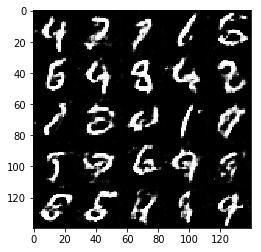

Epoch 1/2 Step 1310... Discriminator Loss: 0.6349... Generator Loss: 1.7921   difference (D-G): -1.1572
Epoch 1/2 Step 1320... Discriminator Loss: 1.5470... Generator Loss: 0.4856   difference (D-G): 1.0614
Epoch 1/2 Step 1330... Discriminator Loss: 0.6253... Generator Loss: 1.8169   difference (D-G): -1.1917
Epoch 1/2 Step 1340... Discriminator Loss: 1.4318... Generator Loss: 0.5278   difference (D-G): 0.9040
Epoch 1/2 Step 1350... Discriminator Loss: 1.2980... Generator Loss: 0.6196   difference (D-G): 0.6784
Epoch 1/2 Step 1360... Discriminator Loss: 1.1624... Generator Loss: 0.6709   difference (D-G): 0.4915
Epoch 1/2 Step 1370... Discriminator Loss: 1.0995... Generator Loss: 0.6924   difference (D-G): 0.4071
Epoch 1/2 Step 1380... Discriminator Loss: 1.5820... Generator Loss: 0.4159   difference (D-G): 1.1662
Epoch 1/2 Step 1390... Discriminator Loss: 1.5178... Generator Loss: 0.4403   difference (D-G): 1.0775
Epoch 1/2 Step 1400... Discriminator Loss: 0.8355... Generator Loss: 1.

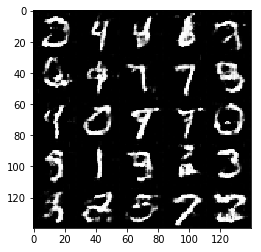

Epoch 1/2 Step 1410... Discriminator Loss: 0.8897... Generator Loss: 1.0016   difference (D-G): -0.1120
Epoch 1/2 Step 1420... Discriminator Loss: 1.3531... Generator Loss: 0.5769   difference (D-G): 0.7762
Epoch 1/2 Step 1430... Discriminator Loss: 0.7104... Generator Loss: 2.4753   difference (D-G): -1.7649
Epoch 1/2 Step 1440... Discriminator Loss: 0.8351... Generator Loss: 1.2430   difference (D-G): -0.4079
Epoch 1/2 Step 1450... Discriminator Loss: 0.6143... Generator Loss: 1.8379   difference (D-G): -1.2236
Epoch 1/2 Step 1460... Discriminator Loss: 0.7251... Generator Loss: 1.6886   difference (D-G): -0.9635
Epoch 1/2 Step 1470... Discriminator Loss: 0.8683... Generator Loss: 1.1604   difference (D-G): -0.2921
Epoch 1/2 Step 1480... Discriminator Loss: 1.6200... Generator Loss: 0.4877   difference (D-G): 1.1323
Epoch 1/2 Step 1490... Discriminator Loss: 1.0667... Generator Loss: 0.7424   difference (D-G): 0.3243
Epoch 1/2 Step 1500... Discriminator Loss: 0.7029... Generator Loss

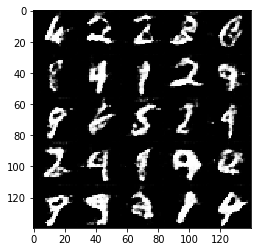

Epoch 1/2 Step 1510... Discriminator Loss: 0.9604... Generator Loss: 0.7989   difference (D-G): 0.1616
Epoch 1/2 Step 1520... Discriminator Loss: 0.7995... Generator Loss: 1.5230   difference (D-G): -0.7235
Epoch 1/2 Step 1530... Discriminator Loss: 1.2244... Generator Loss: 0.7417   difference (D-G): 0.4827
Epoch 1/2 Step 1540... Discriminator Loss: 0.7560... Generator Loss: 1.2156   difference (D-G): -0.4597
Epoch 1/2 Step 1550... Discriminator Loss: 1.1676... Generator Loss: 0.7524   difference (D-G): 0.4152
Epoch 1/2 Step 1560... Discriminator Loss: 1.9178... Generator Loss: 0.3880   difference (D-G): 1.5298
Epoch 1/2 Step 1570... Discriminator Loss: 1.2561... Generator Loss: 0.6499   difference (D-G): 0.6062
Epoch 1/2 Step 1580... Discriminator Loss: 0.8483... Generator Loss: 1.1307   difference (D-G): -0.2824
Epoch 1/2 Step 1590... Discriminator Loss: 1.4869... Generator Loss: 0.5378   difference (D-G): 0.9491
Epoch 1/2 Step 1600... Discriminator Loss: 0.7907... Generator Loss: 1

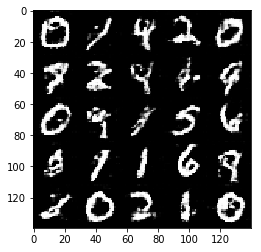

Epoch 1/2 Step 1610... Discriminator Loss: 0.7835... Generator Loss: 1.2145   difference (D-G): -0.4310
Epoch 1/2 Step 1620... Discriminator Loss: 2.3576... Generator Loss: 0.2274   difference (D-G): 2.1302
Epoch 1/2 Step 1630... Discriminator Loss: 2.0582... Generator Loss: 0.3547   difference (D-G): 1.7034
Epoch 1/2 Step 1640... Discriminator Loss: 0.8052... Generator Loss: 2.7567   difference (D-G): -1.9516
Epoch 1/2 Step 1650... Discriminator Loss: 1.2412... Generator Loss: 0.6014   difference (D-G): 0.6398
Epoch 1/2 Step 1660... Discriminator Loss: 0.9076... Generator Loss: 1.6212   difference (D-G): -0.7137
Epoch 1/2 Step 1670... Discriminator Loss: 1.6218... Generator Loss: 0.4345   difference (D-G): 1.1872
Epoch 1/2 Step 1680... Discriminator Loss: 2.4442... Generator Loss: 5.2192   difference (D-G): -2.7750
Epoch 1/2 Step 1690... Discriminator Loss: 0.9306... Generator Loss: 0.9260   difference (D-G): 0.0047
Epoch 1/2 Step 1700... Discriminator Loss: 1.4857... Generator Loss: 

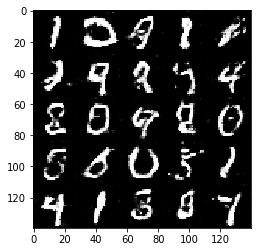

Epoch 1/2 Step 1710... Discriminator Loss: 1.0906... Generator Loss: 0.7127   difference (D-G): 0.3779
Epoch 1/2 Step 1720... Discriminator Loss: 0.4581... Generator Loss: 3.0314   difference (D-G): -2.5733
Epoch 1/2 Step 1730... Discriminator Loss: 1.1767... Generator Loss: 0.7171   difference (D-G): 0.4597
Epoch 1/2 Step 1740... Discriminator Loss: 0.5181... Generator Loss: 1.9919   difference (D-G): -1.4737
Epoch 1/2 Step 1750... Discriminator Loss: 1.7374... Generator Loss: 0.4123   difference (D-G): 1.3251
Epoch 1/2 Step 1760... Discriminator Loss: 0.6815... Generator Loss: 1.4672   difference (D-G): -0.7857
Epoch 1/2 Step 1770... Discriminator Loss: 1.0488... Generator Loss: 0.7801   difference (D-G): 0.2688
Epoch 1/2 Step 1780... Discriminator Loss: 0.5306... Generator Loss: 1.9811   difference (D-G): -1.4506
Epoch 1/2 Step 1790... Discriminator Loss: 3.1301... Generator Loss: 0.1353   difference (D-G): 2.9949
Epoch 1/2 Step 1800... Discriminator Loss: 0.5762... Generator Loss: 

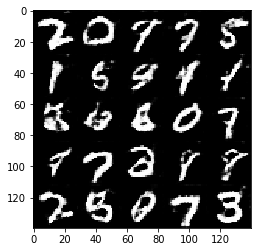

Epoch 1/2 Step 1810... Discriminator Loss: 0.7472... Generator Loss: 1.2323   difference (D-G): -0.4851
Epoch 1/2 Step 1820... Discriminator Loss: 0.6511... Generator Loss: 1.5274   difference (D-G): -0.8763
Epoch 1/2 Step 1830... Discriminator Loss: 1.3718... Generator Loss: 0.4828   difference (D-G): 0.8890
Epoch 1/2 Step 1840... Discriminator Loss: 1.8195... Generator Loss: 0.3035   difference (D-G): 1.5160
Epoch 1/2 Step 1850... Discriminator Loss: 1.2226... Generator Loss: 0.5881   difference (D-G): 0.6346
Epoch 1/2 Step 1860... Discriminator Loss: 1.1567... Generator Loss: 0.9448   difference (D-G): 0.2119
Epoch 1/2 Step 1870... Discriminator Loss: 0.4964... Generator Loss: 2.6074   difference (D-G): -2.1111
Epoch 2/2 Step 1880... Discriminator Loss: 0.6717... Generator Loss: 1.5329   difference (D-G): -0.8612
Epoch 2/2 Step 1890... Discriminator Loss: 0.6453... Generator Loss: 1.7830   difference (D-G): -1.1376
Epoch 2/2 Step 1900... Discriminator Loss: 0.8609... Generator Loss:

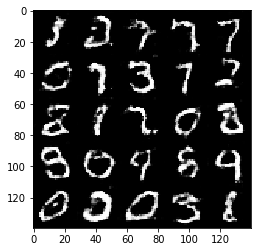

Epoch 2/2 Step 1910... Discriminator Loss: 1.0300... Generator Loss: 0.8598   difference (D-G): 0.1701
Epoch 2/2 Step 1920... Discriminator Loss: 1.1607... Generator Loss: 0.6240   difference (D-G): 0.5367
Epoch 2/2 Step 1930... Discriminator Loss: 0.5775... Generator Loss: 2.1713   difference (D-G): -1.5938
Epoch 2/2 Step 1940... Discriminator Loss: 1.6264... Generator Loss: 0.4067   difference (D-G): 1.2197
Epoch 2/2 Step 1950... Discriminator Loss: 1.3127... Generator Loss: 0.5384   difference (D-G): 0.7742
Epoch 2/2 Step 1960... Discriminator Loss: 0.7390... Generator Loss: 1.4323   difference (D-G): -0.6933
Epoch 2/2 Step 1970... Discriminator Loss: 1.3836... Generator Loss: 0.5852   difference (D-G): 0.7984
Epoch 2/2 Step 1980... Discriminator Loss: 1.9284... Generator Loss: 0.5178   difference (D-G): 1.4105
Epoch 2/2 Step 1990... Discriminator Loss: 1.5025... Generator Loss: 0.4479   difference (D-G): 1.0546
Epoch 2/2 Step 2000... Discriminator Loss: 0.5563... Generator Loss: 1.

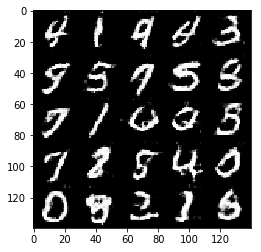

Epoch 2/2 Step 2010... Discriminator Loss: 0.4511... Generator Loss: 2.9596   difference (D-G): -2.5085
Epoch 2/2 Step 2020... Discriminator Loss: 0.7143... Generator Loss: 1.6099   difference (D-G): -0.8956
Epoch 2/2 Step 2030... Discriminator Loss: 1.7768... Generator Loss: 0.4769   difference (D-G): 1.2999
Epoch 2/2 Step 2040... Discriminator Loss: 1.7116... Generator Loss: 0.3722   difference (D-G): 1.3394
Epoch 2/2 Step 2050... Discriminator Loss: 0.5663... Generator Loss: 3.5576   difference (D-G): -2.9913
Epoch 2/2 Step 2060... Discriminator Loss: 0.7553... Generator Loss: 1.7563   difference (D-G): -1.0009
Epoch 2/2 Step 2070... Discriminator Loss: 0.9747... Generator Loss: 0.8309   difference (D-G): 0.1438
Epoch 2/2 Step 2080... Discriminator Loss: 2.2090... Generator Loss: 0.2296   difference (D-G): 1.9795
Epoch 2/2 Step 2090... Discriminator Loss: 0.6402... Generator Loss: 1.6315   difference (D-G): -0.9913
Epoch 2/2 Step 2100... Discriminator Loss: 0.7212... Generator Loss:

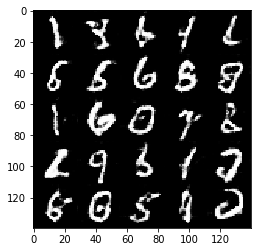

Epoch 2/2 Step 2110... Discriminator Loss: 1.1352... Generator Loss: 0.7751   difference (D-G): 0.3601
Epoch 2/2 Step 2120... Discriminator Loss: 0.8687... Generator Loss: 2.7568   difference (D-G): -1.8881
Epoch 2/2 Step 2130... Discriminator Loss: 1.7890... Generator Loss: 0.4211   difference (D-G): 1.3679
Epoch 2/2 Step 2140... Discriminator Loss: 0.8392... Generator Loss: 0.9642   difference (D-G): -0.1250
Epoch 2/2 Step 2150... Discriminator Loss: 0.6727... Generator Loss: 1.2700   difference (D-G): -0.5973
Epoch 2/2 Step 2160... Discriminator Loss: 0.6431... Generator Loss: 3.8999   difference (D-G): -3.2569
Epoch 2/2 Step 2170... Discriminator Loss: 0.6847... Generator Loss: 1.4570   difference (D-G): -0.7723
Epoch 2/2 Step 2180... Discriminator Loss: 1.6442... Generator Loss: 0.4632   difference (D-G): 1.1810
Epoch 2/2 Step 2190... Discriminator Loss: 1.1741... Generator Loss: 0.8506   difference (D-G): 0.3235
Epoch 2/2 Step 2200... Discriminator Loss: 0.7831... Generator Loss:

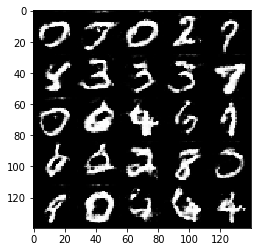

Epoch 2/2 Step 2210... Discriminator Loss: 2.2436... Generator Loss: 0.2893   difference (D-G): 1.9542
Epoch 2/2 Step 2220... Discriminator Loss: 1.4940... Generator Loss: 0.6328   difference (D-G): 0.8611
Epoch 2/2 Step 2230... Discriminator Loss: 0.6204... Generator Loss: 1.5042   difference (D-G): -0.8838
Epoch 2/2 Step 2240... Discriminator Loss: 0.5970... Generator Loss: 2.5284   difference (D-G): -1.9314
Epoch 2/2 Step 2250... Discriminator Loss: 1.4108... Generator Loss: 0.6077   difference (D-G): 0.8031
Epoch 2/2 Step 2260... Discriminator Loss: 1.5345... Generator Loss: 0.3981   difference (D-G): 1.1363
Epoch 2/2 Step 2270... Discriminator Loss: 0.7005... Generator Loss: 1.4027   difference (D-G): -0.7022
Epoch 2/2 Step 2280... Discriminator Loss: 1.0428... Generator Loss: 0.8350   difference (D-G): 0.2078
Epoch 2/2 Step 2290... Discriminator Loss: 0.5948... Generator Loss: 2.1537   difference (D-G): -1.5588
Epoch 2/2 Step 2300... Discriminator Loss: 0.5398... Generator Loss: 

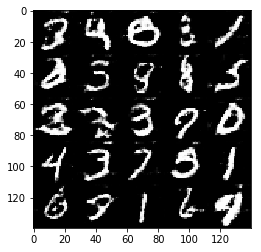

Epoch 2/2 Step 2310... Discriminator Loss: 0.7110... Generator Loss: 1.4509   difference (D-G): -0.7399
Epoch 2/2 Step 2320... Discriminator Loss: 0.5269... Generator Loss: 2.1842   difference (D-G): -1.6573
Epoch 2/2 Step 2330... Discriminator Loss: 0.9174... Generator Loss: 0.9232   difference (D-G): -0.0058
Epoch 2/2 Step 2340... Discriminator Loss: 1.4974... Generator Loss: 0.4835   difference (D-G): 1.0139
Epoch 2/2 Step 2350... Discriminator Loss: 0.7008... Generator Loss: 1.5715   difference (D-G): -0.8707
Epoch 2/2 Step 2360... Discriminator Loss: 1.6783... Generator Loss: 0.4445   difference (D-G): 1.2338
Epoch 2/2 Step 2370... Discriminator Loss: 0.6746... Generator Loss: 1.3097   difference (D-G): -0.6350
Epoch 2/2 Step 2380... Discriminator Loss: 1.9893... Generator Loss: 0.4500   difference (D-G): 1.5392
Epoch 2/2 Step 2390... Discriminator Loss: 1.0759... Generator Loss: 0.6851   difference (D-G): 0.3908
Epoch 2/2 Step 2400... Discriminator Loss: 0.6140... Generator Loss:

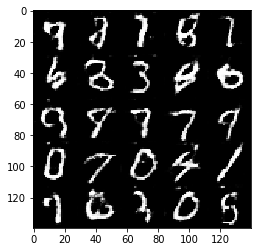

Epoch 2/2 Step 2410... Discriminator Loss: 1.5431... Generator Loss: 0.5944   difference (D-G): 0.9488
Epoch 2/2 Step 2420... Discriminator Loss: 0.5318... Generator Loss: 2.0709   difference (D-G): -1.5391
Epoch 2/2 Step 2430... Discriminator Loss: 0.4764... Generator Loss: 2.2726   difference (D-G): -1.7962
Epoch 2/2 Step 2440... Discriminator Loss: 2.2063... Generator Loss: 0.3377   difference (D-G): 1.8686
Epoch 2/2 Step 2450... Discriminator Loss: 1.0999... Generator Loss: 0.7179   difference (D-G): 0.3820
Epoch 2/2 Step 2460... Discriminator Loss: 1.2750... Generator Loss: 0.6136   difference (D-G): 0.6614
Epoch 2/2 Step 2470... Discriminator Loss: 0.7007... Generator Loss: 1.4270   difference (D-G): -0.7263
Epoch 2/2 Step 2480... Discriminator Loss: 0.5668... Generator Loss: 2.5644   difference (D-G): -1.9977
Epoch 2/2 Step 2490... Discriminator Loss: 0.7824... Generator Loss: 1.2317   difference (D-G): -0.4492
Epoch 2/2 Step 2500... Discriminator Loss: 1.0702... Generator Loss:

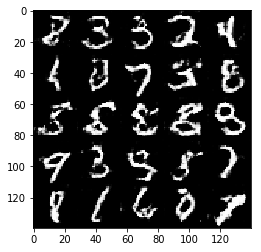

Epoch 2/2 Step 2510... Discriminator Loss: 0.6809... Generator Loss: 1.5779   difference (D-G): -0.8970
Epoch 2/2 Step 2520... Discriminator Loss: 0.6819... Generator Loss: 1.3149   difference (D-G): -0.6330
Epoch 2/2 Step 2530... Discriminator Loss: 0.7468... Generator Loss: 1.3893   difference (D-G): -0.6425
Epoch 2/2 Step 2540... Discriminator Loss: 0.8617... Generator Loss: 1.1885   difference (D-G): -0.3269
Epoch 2/2 Step 2550... Discriminator Loss: 0.4446... Generator Loss: 3.0159   difference (D-G): -2.5713
Epoch 2/2 Step 2560... Discriminator Loss: 0.6797... Generator Loss: 2.1573   difference (D-G): -1.4776
Epoch 2/2 Step 2570... Discriminator Loss: 0.6960... Generator Loss: 1.4273   difference (D-G): -0.7313
Epoch 2/2 Step 2580... Discriminator Loss: 0.5768... Generator Loss: 1.7452   difference (D-G): -1.1684
Epoch 2/2 Step 2590... Discriminator Loss: 1.5524... Generator Loss: 0.5319   difference (D-G): 1.0204
Epoch 2/2 Step 2600... Discriminator Loss: 0.6642... Generator Lo

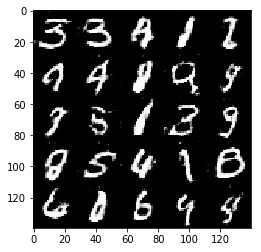

Epoch 2/2 Step 2610... Discriminator Loss: 1.6286... Generator Loss: 0.4178   difference (D-G): 1.2108
Epoch 2/2 Step 2620... Discriminator Loss: 0.6533... Generator Loss: 1.6209   difference (D-G): -0.9676
Epoch 2/2 Step 2630... Discriminator Loss: 1.9019... Generator Loss: 0.3573   difference (D-G): 1.5446
Epoch 2/2 Step 2640... Discriminator Loss: 0.5986... Generator Loss: 1.9078   difference (D-G): -1.3092
Epoch 2/2 Step 2650... Discriminator Loss: 0.5111... Generator Loss: 2.0709   difference (D-G): -1.5598
Epoch 2/2 Step 2660... Discriminator Loss: 2.0172... Generator Loss: 0.2937   difference (D-G): 1.7235
Epoch 2/2 Step 2670... Discriminator Loss: 0.9679... Generator Loss: 2.8681   difference (D-G): -1.9003
Epoch 2/2 Step 2680... Discriminator Loss: 0.8367... Generator Loss: 0.9852   difference (D-G): -0.1485
Epoch 2/2 Step 2690... Discriminator Loss: 0.5502... Generator Loss: 2.1030   difference (D-G): -1.5528
Epoch 2/2 Step 2700... Discriminator Loss: 0.7713... Generator Loss

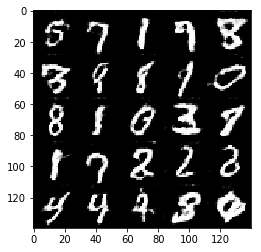

Epoch 2/2 Step 2710... Discriminator Loss: 0.6508... Generator Loss: 1.8489   difference (D-G): -1.1981
Epoch 2/2 Step 2720... Discriminator Loss: 1.1458... Generator Loss: 0.6772   difference (D-G): 0.4686
Epoch 2/2 Step 2730... Discriminator Loss: 1.1242... Generator Loss: 0.7798   difference (D-G): 0.3443
Epoch 2/2 Step 2740... Discriminator Loss: 1.2328... Generator Loss: 0.8239   difference (D-G): 0.4089
Epoch 2/2 Step 2750... Discriminator Loss: 0.8837... Generator Loss: 1.1935   difference (D-G): -0.3098
Epoch 2/2 Step 2760... Discriminator Loss: 0.8447... Generator Loss: 1.1510   difference (D-G): -0.3063
Epoch 2/2 Step 2770... Discriminator Loss: 0.7164... Generator Loss: 1.6223   difference (D-G): -0.9059
Epoch 2/2 Step 2780... Discriminator Loss: 1.2249... Generator Loss: 0.8268   difference (D-G): 0.3981
Epoch 2/2 Step 2790... Discriminator Loss: 0.6716... Generator Loss: 2.7670   difference (D-G): -2.0954
Epoch 2/2 Step 2800... Discriminator Loss: 0.5772... Generator Loss:

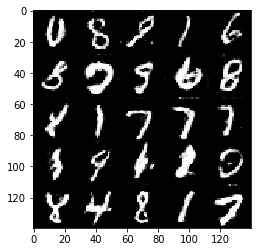

Epoch 2/2 Step 2810... Discriminator Loss: 0.6635... Generator Loss: 1.5767   difference (D-G): -0.9132
Epoch 2/2 Step 2820... Discriminator Loss: 0.6662... Generator Loss: 2.4175   difference (D-G): -1.7513
Epoch 2/2 Step 2830... Discriminator Loss: 0.3983... Generator Loss: 3.3024   difference (D-G): -2.9041
Epoch 2/2 Step 2840... Discriminator Loss: 0.5667... Generator Loss: 2.2179   difference (D-G): -1.6512
Epoch 2/2 Step 2850... Discriminator Loss: 2.5691... Generator Loss: 0.1701   difference (D-G): 2.3990
Epoch 2/2 Step 2860... Discriminator Loss: 0.7271... Generator Loss: 1.3761   difference (D-G): -0.6490
Epoch 2/2 Step 2870... Discriminator Loss: 0.7154... Generator Loss: 1.3948   difference (D-G): -0.6795
Epoch 2/2 Step 2880... Discriminator Loss: 0.9134... Generator Loss: 1.0242   difference (D-G): -0.1108
Epoch 2/2 Step 2890... Discriminator Loss: 0.6306... Generator Loss: 1.6122   difference (D-G): -0.9816
Epoch 2/2 Step 2900... Discriminator Loss: 0.3760... Generator Lo

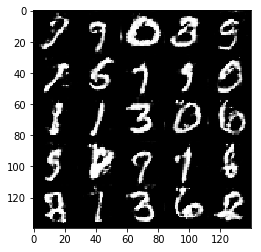

Epoch 2/2 Step 2910... Discriminator Loss: 1.9298... Generator Loss: 0.4254   difference (D-G): 1.5044
Epoch 2/2 Step 2920... Discriminator Loss: 0.5551... Generator Loss: 2.0405   difference (D-G): -1.4854
Epoch 2/2 Step 2930... Discriminator Loss: 0.5406... Generator Loss: 2.0422   difference (D-G): -1.5017
Epoch 2/2 Step 2940... Discriminator Loss: 0.7342... Generator Loss: 1.3884   difference (D-G): -0.6542
Epoch 2/2 Step 2950... Discriminator Loss: 0.5993... Generator Loss: 1.6018   difference (D-G): -1.0026
Epoch 2/2 Step 2960... Discriminator Loss: 0.8672... Generator Loss: 1.1229   difference (D-G): -0.2557
Epoch 2/2 Step 2970... Discriminator Loss: 0.9302... Generator Loss: 0.8553   difference (D-G): 0.0749
Epoch 2/2 Step 2980... Discriminator Loss: 3.8659... Generator Loss: 0.0587   difference (D-G): 3.8072
Epoch 2/2 Step 2990... Discriminator Loss: 0.6701... Generator Loss: 1.4238   difference (D-G): -0.7538
Epoch 2/2 Step 3000... Discriminator Loss: 0.8105... Generator Loss

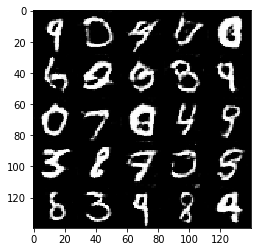

Epoch 2/2 Step 3010... Discriminator Loss: 0.7135... Generator Loss: 2.0897   difference (D-G): -1.3761
Epoch 2/2 Step 3020... Discriminator Loss: 1.5058... Generator Loss: 0.6061   difference (D-G): 0.8997
Epoch 2/2 Step 3030... Discriminator Loss: 1.5214... Generator Loss: 0.5186   difference (D-G): 1.0028
Epoch 2/2 Step 3040... Discriminator Loss: 0.6734... Generator Loss: 1.5454   difference (D-G): -0.8720
Epoch 2/2 Step 3050... Discriminator Loss: 0.7680... Generator Loss: 1.1487   difference (D-G): -0.3807
Epoch 2/2 Step 3060... Discriminator Loss: 0.5923... Generator Loss: 2.4689   difference (D-G): -1.8766
Epoch 2/2 Step 3070... Discriminator Loss: 1.4436... Generator Loss: 5.6758   difference (D-G): -4.2322
Epoch 2/2 Step 3080... Discriminator Loss: 1.0317... Generator Loss: 3.6287   difference (D-G): -2.5970
Epoch 2/2 Step 3090... Discriminator Loss: 0.7409... Generator Loss: 1.5426   difference (D-G): -0.8017
Epoch 2/2 Step 3100... Discriminator Loss: 1.3757... Generator Los

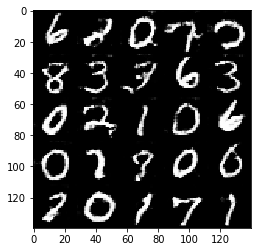

Epoch 2/2 Step 3110... Discriminator Loss: 0.6973... Generator Loss: 2.6781   difference (D-G): -1.9808
Epoch 2/2 Step 3120... Discriminator Loss: 0.5216... Generator Loss: 2.0468   difference (D-G): -1.5252
Epoch 2/2 Step 3130... Discriminator Loss: 0.6441... Generator Loss: 1.5506   difference (D-G): -0.9065
Epoch 2/2 Step 3140... Discriminator Loss: 0.4877... Generator Loss: 2.3776   difference (D-G): -1.8898
Epoch 2/2 Step 3150... Discriminator Loss: 0.5298... Generator Loss: 2.2970   difference (D-G): -1.7672
Epoch 2/2 Step 3160... Discriminator Loss: 0.4771... Generator Loss: 2.0660   difference (D-G): -1.5889
Epoch 2/2 Step 3170... Discriminator Loss: 0.7925... Generator Loss: 1.3049   difference (D-G): -0.5124
Epoch 2/2 Step 3180... Discriminator Loss: 0.5567... Generator Loss: 2.2202   difference (D-G): -1.6635
Epoch 2/2 Step 3190... Discriminator Loss: 0.7612... Generator Loss: 1.1680   difference (D-G): -0.4068
Epoch 2/2 Step 3200... Discriminator Loss: 1.0246... Generator L

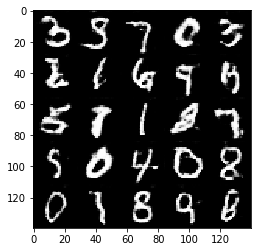

Epoch 2/2 Step 3210... Discriminator Loss: 0.4527... Generator Loss: 2.4521   difference (D-G): -1.9994
Epoch 2/2 Step 3220... Discriminator Loss: 0.8077... Generator Loss: 1.1492   difference (D-G): -0.3416
Epoch 2/2 Step 3230... Discriminator Loss: 0.3909... Generator Loss: 3.4174   difference (D-G): -3.0265
Epoch 2/2 Step 3240... Discriminator Loss: 0.6341... Generator Loss: 1.5304   difference (D-G): -0.8963
Epoch 2/2 Step 3250... Discriminator Loss: 0.5045... Generator Loss: 2.5621   difference (D-G): -2.0577
Epoch 2/2 Step 3260... Discriminator Loss: 0.9986... Generator Loss: 0.7804   difference (D-G): 0.2183
Epoch 2/2 Step 3270... Discriminator Loss: 0.4297... Generator Loss: 2.7291   difference (D-G): -2.2995
Epoch 2/2 Step 3280... Discriminator Loss: 0.4896... Generator Loss: 2.2168   difference (D-G): -1.7272
Epoch 2/2 Step 3290... Discriminator Loss: 0.5675... Generator Loss: 1.8546   difference (D-G): -1.2871
Epoch 2/2 Step 3300... Discriminator Loss: 0.8343... Generator Lo

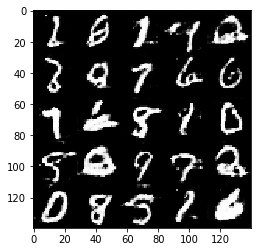

Epoch 2/2 Step 3310... Discriminator Loss: 0.9292... Generator Loss: 0.8671   difference (D-G): 0.0621
Epoch 2/2 Step 3320... Discriminator Loss: 0.6866... Generator Loss: 1.3534   difference (D-G): -0.6668
Epoch 2/2 Step 3330... Discriminator Loss: 0.9465... Generator Loss: 1.1078   difference (D-G): -0.1612
Epoch 2/2 Step 3340... Discriminator Loss: 0.7542... Generator Loss: 1.3147   difference (D-G): -0.5605
Epoch 2/2 Step 3350... Discriminator Loss: 0.5126... Generator Loss: 2.3172   difference (D-G): -1.8046
Epoch 2/2 Step 3360... Discriminator Loss: 0.4939... Generator Loss: 2.2587   difference (D-G): -1.7648
Epoch 2/2 Step 3370... Discriminator Loss: 0.8114... Generator Loss: 1.2763   difference (D-G): -0.4649
Epoch 2/2 Step 3380... Discriminator Loss: 2.1626... Generator Loss: 0.2819   difference (D-G): 1.8807
Epoch 2/2 Step 3390... Discriminator Loss: 0.6728... Generator Loss: 1.3021   difference (D-G): -0.6292
Epoch 2/2 Step 3400... Discriminator Loss: 1.0802... Generator Los

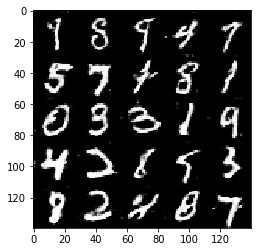

Epoch 2/2 Step 3410... Discriminator Loss: 0.5675... Generator Loss: 2.0964   difference (D-G): -1.5289
Epoch 2/2 Step 3420... Discriminator Loss: 0.5411... Generator Loss: 1.9859   difference (D-G): -1.4448
Epoch 2/2 Step 3430... Discriminator Loss: 1.9116... Generator Loss: 0.4037   difference (D-G): 1.5079
Epoch 2/2 Step 3440... Discriminator Loss: 0.6318... Generator Loss: 1.5918   difference (D-G): -0.9600
Epoch 2/2 Step 3450... Discriminator Loss: 0.6074... Generator Loss: 1.6744   difference (D-G): -1.0669
Epoch 2/2 Step 3460... Discriminator Loss: 0.4890... Generator Loss: 2.2561   difference (D-G): -1.7671
Epoch 2/2 Step 3470... Discriminator Loss: 0.4485... Generator Loss: 2.5095   difference (D-G): -2.0610
Epoch 2/2 Step 3480... Discriminator Loss: 1.5108... Generator Loss: 0.5519   difference (D-G): 0.9589
Epoch 2/2 Step 3490... Discriminator Loss: 0.4773... Generator Loss: 2.3591   difference (D-G): -1.8818
Epoch 2/2 Step 3500... Discriminator Loss: 0.6726... Generator Los

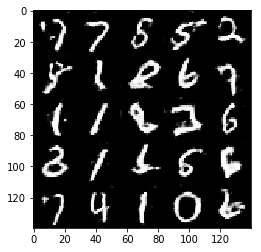

Epoch 2/2 Step 3510... Discriminator Loss: 2.7970... Generator Loss: 0.1712   difference (D-G): 2.6258
Epoch 2/2 Step 3520... Discriminator Loss: 0.7866... Generator Loss: 1.3462   difference (D-G): -0.5596
Epoch 2/2 Step 3530... Discriminator Loss: 0.7435... Generator Loss: 1.4117   difference (D-G): -0.6682
Epoch 2/2 Step 3540... Discriminator Loss: 0.7093... Generator Loss: 1.3931   difference (D-G): -0.6838
Epoch 2/2 Step 3550... Discriminator Loss: 0.7998... Generator Loss: 1.4063   difference (D-G): -0.6065
Epoch 2/2 Step 3560... Discriminator Loss: 0.5665... Generator Loss: 1.9604   difference (D-G): -1.3940
Epoch 2/2 Step 3570... Discriminator Loss: 0.8070... Generator Loss: 1.5439   difference (D-G): -0.7369
Epoch 2/2 Step 3580... Discriminator Loss: 1.4411... Generator Loss: 0.7998   difference (D-G): 0.6413
Epoch 2/2 Step 3590... Discriminator Loss: 0.5812... Generator Loss: 3.1217   difference (D-G): -2.5405
Epoch 2/2 Step 3600... Discriminator Loss: 0.7188... Generator Los

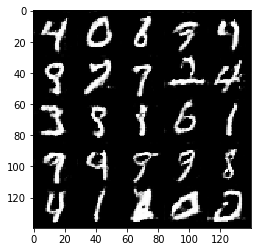

Epoch 2/2 Step 3610... Discriminator Loss: 0.6378... Generator Loss: 1.4502   difference (D-G): -0.8125
Epoch 2/2 Step 3620... Discriminator Loss: 1.0265... Generator Loss: 0.7831   difference (D-G): 0.2434
Epoch 2/2 Step 3630... Discriminator Loss: 0.6865... Generator Loss: 1.5237   difference (D-G): -0.8372
Epoch 2/2 Step 3640... Discriminator Loss: 0.3720... Generator Loss: 4.6014   difference (D-G): -4.2294
Epoch 2/2 Step 3650... Discriminator Loss: 0.5726... Generator Loss: 1.9258   difference (D-G): -1.3532
Epoch 2/2 Step 3660... Discriminator Loss: 2.4534... Generator Loss: 0.2017   difference (D-G): 2.2517
Epoch 2/2 Step 3670... Discriminator Loss: 0.7476... Generator Loss: 2.7612   difference (D-G): -2.0136
Epoch 2/2 Step 3680... Discriminator Loss: 1.7369... Generator Loss: 0.5669   difference (D-G): 1.1700
Epoch 2/2 Step 3690... Discriminator Loss: 1.0183... Generator Loss: 0.8061   difference (D-G): 0.2123
Epoch 2/2 Step 3700... Discriminator Loss: 0.4992... Generator Loss:

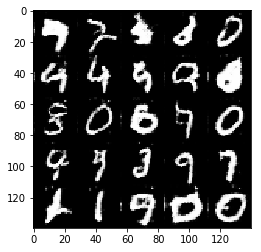

Epoch 2/2 Step 3710... Discriminator Loss: 0.6765... Generator Loss: 1.5677   difference (D-G): -0.8913
Epoch 2/2 Step 3720... Discriminator Loss: 1.4141... Generator Loss: 0.5918   difference (D-G): 0.8222
Epoch 2/2 Step 3730... Discriminator Loss: 0.6673... Generator Loss: 1.4448   difference (D-G): -0.7776
Epoch 2/2 Step 3740... Discriminator Loss: 0.4620... Generator Loss: 2.4744   difference (D-G): -2.0124
Epoch 2/2 Step 3750... Discriminator Loss: 1.1802... Generator Loss: 0.6412   difference (D-G): 0.5390


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Step 10... Discriminator Loss: 1.4526... Generator Loss: 10.1895   difference (D-G): -8.7368
Epoch 1/1 Step 20... Discriminator Loss: 0.5184... Generator Loss: 10.5292   difference (D-G): -10.0108
Epoch 1/1 Step 30... Discriminator Loss: 0.5480... Generator Loss: 14.2640   difference (D-G): -13.7160
Epoch 1/1 Step 40... Discriminator Loss: 0.6575... Generator Loss: 1.5052   difference (D-G): -0.8477
Epoch 1/1 Step 50... Discriminator Loss: 1.0565... Generator Loss: 9.8350   difference (D-G): -8.7786
Epoch 1/1 Step 60... Discriminator Loss: 0.9757... Generator Loss: 0.8655   difference (D-G): 0.1103
Epoch 1/1 Step 70... Discriminator Loss: 0.4897... Generator Loss: 7.5909   difference (D-G): -7.1012
Epoch 1/1 Step 80... Discriminator Loss: 0.3714... Generator Loss: 5.0666   difference (D-G): -4.6952
Epoch 1/1 Step 90... Discriminator Loss: 2.1996... Generator Loss: 0.1873   difference (D-G): 2.0123
Epoch 1/1 Step 100... Discriminator Loss: 0.3780... Generator Loss: 7.9712   di

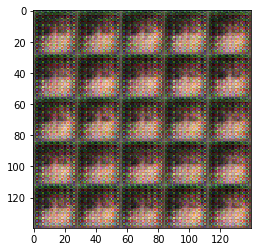

Epoch 1/1 Step 110... Discriminator Loss: 1.0770... Generator Loss: 0.9139   difference (D-G): 0.1632
Epoch 1/1 Step 120... Discriminator Loss: 0.4233... Generator Loss: 3.9948   difference (D-G): -3.5715
Epoch 1/1 Step 130... Discriminator Loss: 0.4856... Generator Loss: 2.2717   difference (D-G): -1.7861
Epoch 1/1 Step 140... Discriminator Loss: 1.1057... Generator Loss: 0.7720   difference (D-G): 0.3336
Epoch 1/1 Step 150... Discriminator Loss: 0.6974... Generator Loss: 3.3123   difference (D-G): -2.6149
Epoch 1/1 Step 160... Discriminator Loss: 0.5589... Generator Loss: 2.2189   difference (D-G): -1.6599
Epoch 1/1 Step 170... Discriminator Loss: 0.7256... Generator Loss: 3.6292   difference (D-G): -2.9036
Epoch 1/1 Step 180... Discriminator Loss: 2.1093... Generator Loss: 0.2875   difference (D-G): 1.8218
Epoch 1/1 Step 190... Discriminator Loss: 0.4336... Generator Loss: 2.7960   difference (D-G): -2.3623
Epoch 1/1 Step 200... Discriminator Loss: 0.8350... Generator Loss: 1.4107  

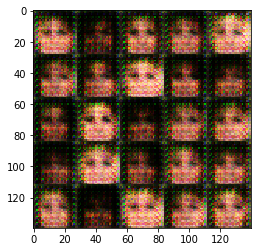

Epoch 1/1 Step 210... Discriminator Loss: 0.6710... Generator Loss: 1.4674   difference (D-G): -0.7963
Epoch 1/1 Step 220... Discriminator Loss: 0.6087... Generator Loss: 2.3656   difference (D-G): -1.7569
Epoch 1/1 Step 230... Discriminator Loss: 0.7619... Generator Loss: 1.7579   difference (D-G): -0.9960
Epoch 1/1 Step 240... Discriminator Loss: 0.7557... Generator Loss: 4.1326   difference (D-G): -3.3769
Epoch 1/1 Step 250... Discriminator Loss: 0.8056... Generator Loss: 1.3069   difference (D-G): -0.5013
Epoch 1/1 Step 260... Discriminator Loss: 0.8668... Generator Loss: 1.4594   difference (D-G): -0.5926
Epoch 1/1 Step 270... Discriminator Loss: 1.3276... Generator Loss: 0.6411   difference (D-G): 0.6866
Epoch 1/1 Step 280... Discriminator Loss: 0.9981... Generator Loss: 0.9378   difference (D-G): 0.0603
Epoch 1/1 Step 290... Discriminator Loss: 1.6923... Generator Loss: 0.4229   difference (D-G): 1.2694
Epoch 1/1 Step 300... Discriminator Loss: 0.9785... Generator Loss: 0.9745  

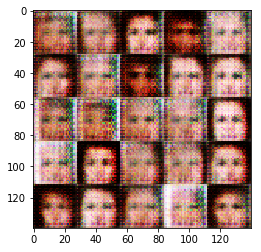

Epoch 1/1 Step 310... Discriminator Loss: 0.8436... Generator Loss: 1.0563   difference (D-G): -0.2127
Epoch 1/1 Step 320... Discriminator Loss: 1.4718... Generator Loss: 0.5045   difference (D-G): 0.9673
Epoch 1/1 Step 330... Discriminator Loss: 0.7067... Generator Loss: 2.9558   difference (D-G): -2.2492
Epoch 1/1 Step 340... Discriminator Loss: 0.9588... Generator Loss: 1.8615   difference (D-G): -0.9027
Epoch 1/1 Step 350... Discriminator Loss: 1.0297... Generator Loss: 0.8302   difference (D-G): 0.1995
Epoch 1/1 Step 360... Discriminator Loss: 1.4748... Generator Loss: 0.4206   difference (D-G): 1.0542
Epoch 1/1 Step 370... Discriminator Loss: 1.0919... Generator Loss: 0.8727   difference (D-G): 0.2193
Epoch 1/1 Step 380... Discriminator Loss: 1.4164... Generator Loss: 3.8751   difference (D-G): -2.4587
Epoch 1/1 Step 390... Discriminator Loss: 0.8656... Generator Loss: 1.1068   difference (D-G): -0.2412
Epoch 1/1 Step 400... Discriminator Loss: 0.9003... Generator Loss: 2.4660   

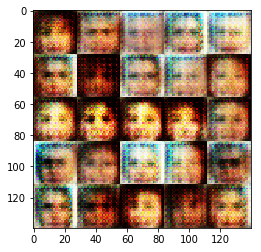

Epoch 1/1 Step 410... Discriminator Loss: 1.3407... Generator Loss: 0.5370   difference (D-G): 0.8037
Epoch 1/1 Step 420... Discriminator Loss: 2.2639... Generator Loss: 0.2146   difference (D-G): 2.0493
Epoch 1/1 Step 430... Discriminator Loss: 0.8380... Generator Loss: 1.0318   difference (D-G): -0.1938
Epoch 1/1 Step 440... Discriminator Loss: 1.1642... Generator Loss: 0.7084   difference (D-G): 0.4558
Epoch 1/1 Step 450... Discriminator Loss: 1.2410... Generator Loss: 0.6152   difference (D-G): 0.6259
Epoch 1/1 Step 460... Discriminator Loss: 1.7893... Generator Loss: 0.3842   difference (D-G): 1.4051
Epoch 1/1 Step 470... Discriminator Loss: 0.9396... Generator Loss: 1.0128   difference (D-G): -0.0732
Epoch 1/1 Step 480... Discriminator Loss: 1.2283... Generator Loss: 0.6195   difference (D-G): 0.6087
Epoch 1/1 Step 490... Discriminator Loss: 0.7770... Generator Loss: 1.6242   difference (D-G): -0.8472
Epoch 1/1 Step 500... Discriminator Loss: 0.8907... Generator Loss: 1.2973   di

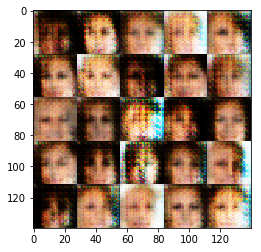

Epoch 1/1 Step 510... Discriminator Loss: 0.8188... Generator Loss: 1.7616   difference (D-G): -0.9428
Epoch 1/1 Step 520... Discriminator Loss: 1.0641... Generator Loss: 4.6779   difference (D-G): -3.6138
Epoch 1/1 Step 530... Discriminator Loss: 0.6267... Generator Loss: 2.4523   difference (D-G): -1.8256
Epoch 1/1 Step 540... Discriminator Loss: 1.6164... Generator Loss: 0.3564   difference (D-G): 1.2600
Epoch 1/1 Step 550... Discriminator Loss: 0.7301... Generator Loss: 2.3735   difference (D-G): -1.6434
Epoch 1/1 Step 560... Discriminator Loss: 1.4320... Generator Loss: 0.5249   difference (D-G): 0.9070
Epoch 1/1 Step 570... Discriminator Loss: 0.8090... Generator Loss: 1.2712   difference (D-G): -0.4622
Epoch 1/1 Step 580... Discriminator Loss: 1.1661... Generator Loss: 0.9554   difference (D-G): 0.2106
Epoch 1/1 Step 590... Discriminator Loss: 1.2296... Generator Loss: 0.6042   difference (D-G): 0.6254
Epoch 1/1 Step 600... Discriminator Loss: 1.2303... Generator Loss: 0.6925   

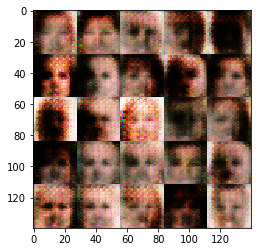

Epoch 1/1 Step 610... Discriminator Loss: 2.3519... Generator Loss: 6.7896   difference (D-G): -4.4377
Epoch 1/1 Step 620... Discriminator Loss: 0.7070... Generator Loss: 1.3725   difference (D-G): -0.6654
Epoch 1/1 Step 630... Discriminator Loss: 0.9082... Generator Loss: 1.2518   difference (D-G): -0.3436
Epoch 1/1 Step 640... Discriminator Loss: 0.8358... Generator Loss: 1.1231   difference (D-G): -0.2872
Epoch 1/1 Step 650... Discriminator Loss: 0.7601... Generator Loss: 2.2221   difference (D-G): -1.4621
Epoch 1/1 Step 660... Discriminator Loss: 1.1568... Generator Loss: 0.6421   difference (D-G): 0.5146
Epoch 1/1 Step 670... Discriminator Loss: 1.0907... Generator Loss: 0.9383   difference (D-G): 0.1524
Epoch 1/1 Step 680... Discriminator Loss: 1.1612... Generator Loss: 0.6707   difference (D-G): 0.4905
Epoch 1/1 Step 690... Discriminator Loss: 0.8283... Generator Loss: 1.6150   difference (D-G): -0.7867
Epoch 1/1 Step 700... Discriminator Loss: 0.9896... Generator Loss: 1.8664  

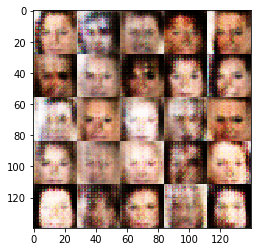

Epoch 1/1 Step 710... Discriminator Loss: 1.1523... Generator Loss: 0.6663   difference (D-G): 0.4860
Epoch 1/1 Step 720... Discriminator Loss: 0.8370... Generator Loss: 2.2130   difference (D-G): -1.3760
Epoch 1/1 Step 730... Discriminator Loss: 0.8103... Generator Loss: 1.1616   difference (D-G): -0.3513
Epoch 1/1 Step 740... Discriminator Loss: 0.9958... Generator Loss: 0.8174   difference (D-G): 0.1784
Epoch 1/1 Step 750... Discriminator Loss: 2.0274... Generator Loss: 0.2278   difference (D-G): 1.7997
Epoch 1/1 Step 760... Discriminator Loss: 0.8719... Generator Loss: 1.0879   difference (D-G): -0.2160
Epoch 1/1 Step 770... Discriminator Loss: 0.9481... Generator Loss: 0.8620   difference (D-G): 0.0861
Epoch 1/1 Step 780... Discriminator Loss: 1.2455... Generator Loss: 0.6735   difference (D-G): 0.5720
Epoch 1/1 Step 790... Discriminator Loss: 0.9009... Generator Loss: 1.2997   difference (D-G): -0.3988
Epoch 1/1 Step 800... Discriminator Loss: 0.9808... Generator Loss: 1.5195   d

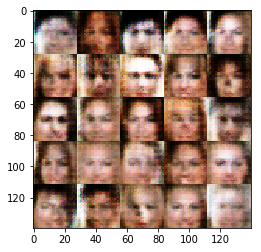

Epoch 1/1 Step 810... Discriminator Loss: 0.7791... Generator Loss: 1.9912   difference (D-G): -1.2121
Epoch 1/1 Step 820... Discriminator Loss: 0.9676... Generator Loss: 1.6794   difference (D-G): -0.7119
Epoch 1/1 Step 830... Discriminator Loss: 0.8929... Generator Loss: 1.3540   difference (D-G): -0.4611
Epoch 1/1 Step 840... Discriminator Loss: 0.9654... Generator Loss: 0.8836   difference (D-G): 0.0819
Epoch 1/1 Step 850... Discriminator Loss: 1.5206... Generator Loss: 0.4103   difference (D-G): 1.1103
Epoch 1/1 Step 860... Discriminator Loss: 0.8039... Generator Loss: 1.5699   difference (D-G): -0.7660
Epoch 1/1 Step 870... Discriminator Loss: 1.1689... Generator Loss: 0.7399   difference (D-G): 0.4290
Epoch 1/1 Step 880... Discriminator Loss: 0.9905... Generator Loss: 0.9171   difference (D-G): 0.0733
Epoch 1/1 Step 890... Discriminator Loss: 0.8245... Generator Loss: 1.2826   difference (D-G): -0.4581
Epoch 1/1 Step 900... Discriminator Loss: 0.8728... Generator Loss: 1.6241   

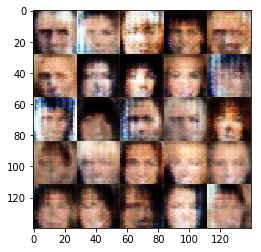

Epoch 1/1 Step 910... Discriminator Loss: 0.7932... Generator Loss: 1.9581   difference (D-G): -1.1648
Epoch 1/1 Step 920... Discriminator Loss: 1.0917... Generator Loss: 0.7584   difference (D-G): 0.3334
Epoch 1/1 Step 930... Discriminator Loss: 1.6487... Generator Loss: 0.3444   difference (D-G): 1.3043
Epoch 1/1 Step 940... Discriminator Loss: 0.9057... Generator Loss: 1.0149   difference (D-G): -0.1091
Epoch 1/1 Step 950... Discriminator Loss: 1.1089... Generator Loss: 0.7029   difference (D-G): 0.4060
Epoch 1/1 Step 960... Discriminator Loss: 0.9680... Generator Loss: 0.9006   difference (D-G): 0.0674
Epoch 1/1 Step 970... Discriminator Loss: 0.9649... Generator Loss: 1.1031   difference (D-G): -0.1382
Epoch 1/1 Step 980... Discriminator Loss: 0.8625... Generator Loss: 1.3155   difference (D-G): -0.4530
Epoch 1/1 Step 990... Discriminator Loss: 1.2801... Generator Loss: 0.5280   difference (D-G): 0.7521
Epoch 1/1 Step 1000... Discriminator Loss: 0.9222... Generator Loss: 1.5008   

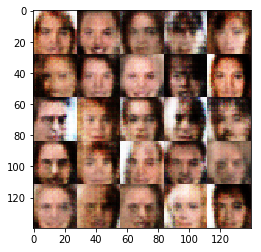

Epoch 1/1 Step 1010... Discriminator Loss: 0.9349... Generator Loss: 1.0357   difference (D-G): -0.1007
Epoch 1/1 Step 1020... Discriminator Loss: 0.9020... Generator Loss: 1.4805   difference (D-G): -0.5785
Epoch 1/1 Step 1030... Discriminator Loss: 0.8371... Generator Loss: 1.0920   difference (D-G): -0.2549
Epoch 1/1 Step 1040... Discriminator Loss: 1.1073... Generator Loss: 0.6783   difference (D-G): 0.4290
Epoch 1/1 Step 1050... Discriminator Loss: 1.5840... Generator Loss: 0.4135   difference (D-G): 1.1704
Epoch 1/1 Step 1060... Discriminator Loss: 1.5003... Generator Loss: 0.4221   difference (D-G): 1.0782
Epoch 1/1 Step 1070... Discriminator Loss: 0.8220... Generator Loss: 1.6671   difference (D-G): -0.8452
Epoch 1/1 Step 1080... Discriminator Loss: 1.5152... Generator Loss: 0.4159   difference (D-G): 1.0993
Epoch 1/1 Step 1090... Discriminator Loss: 0.8908... Generator Loss: 1.4496   difference (D-G): -0.5588
Epoch 1/1 Step 1100... Discriminator Loss: 0.9131... Generator Loss:

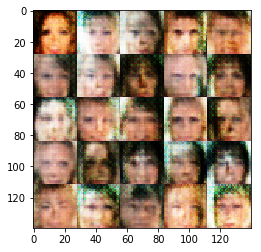

Epoch 1/1 Step 1110... Discriminator Loss: 0.9734... Generator Loss: 0.9967   difference (D-G): -0.0233
Epoch 1/1 Step 1120... Discriminator Loss: 0.7027... Generator Loss: 1.8125   difference (D-G): -1.1097
Epoch 1/1 Step 1130... Discriminator Loss: 0.9128... Generator Loss: 1.0064   difference (D-G): -0.0936
Epoch 1/1 Step 1140... Discriminator Loss: 1.0234... Generator Loss: 0.8301   difference (D-G): 0.1932
Epoch 1/1 Step 1150... Discriminator Loss: 1.2389... Generator Loss: 2.3343   difference (D-G): -1.0954
Epoch 1/1 Step 1160... Discriminator Loss: 0.8622... Generator Loss: 1.0564   difference (D-G): -0.1943
Epoch 1/1 Step 1170... Discriminator Loss: 1.0071... Generator Loss: 0.9469   difference (D-G): 0.0602
Epoch 1/1 Step 1180... Discriminator Loss: 1.2929... Generator Loss: 0.6308   difference (D-G): 0.6621
Epoch 1/1 Step 1190... Discriminator Loss: 1.0136... Generator Loss: 0.7456   difference (D-G): 0.2680
Epoch 1/1 Step 1200... Discriminator Loss: 1.8308... Generator Loss:

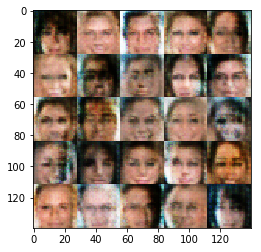

Epoch 1/1 Step 1210... Discriminator Loss: 1.4048... Generator Loss: 0.4620   difference (D-G): 0.9429
Epoch 1/1 Step 1220... Discriminator Loss: 2.1804... Generator Loss: 0.2141   difference (D-G): 1.9663
Epoch 1/1 Step 1230... Discriminator Loss: 1.2387... Generator Loss: 0.5860   difference (D-G): 0.6528
Epoch 1/1 Step 1240... Discriminator Loss: 1.3567... Generator Loss: 0.6062   difference (D-G): 0.7505
Epoch 1/1 Step 1250... Discriminator Loss: 1.2404... Generator Loss: 0.6367   difference (D-G): 0.6037
Epoch 1/1 Step 1260... Discriminator Loss: 0.9328... Generator Loss: 0.8814   difference (D-G): 0.0514
Epoch 1/1 Step 1270... Discriminator Loss: 0.8740... Generator Loss: 1.0320   difference (D-G): -0.1580
Epoch 1/1 Step 1280... Discriminator Loss: 0.8459... Generator Loss: 1.7496   difference (D-G): -0.9038
Epoch 1/1 Step 1290... Discriminator Loss: 0.8405... Generator Loss: 2.2909   difference (D-G): -1.4505
Epoch 1/1 Step 1300... Discriminator Loss: 0.8762... Generator Loss: 1

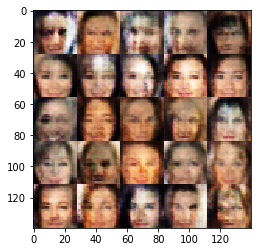

Epoch 1/1 Step 1310... Discriminator Loss: 1.0001... Generator Loss: 1.1013   difference (D-G): -0.1012
Epoch 1/1 Step 1320... Discriminator Loss: 1.2494... Generator Loss: 0.5405   difference (D-G): 0.7089
Epoch 1/1 Step 1330... Discriminator Loss: 0.9076... Generator Loss: 1.0517   difference (D-G): -0.1441
Epoch 1/1 Step 1340... Discriminator Loss: 1.3688... Generator Loss: 0.4780   difference (D-G): 0.8908
Epoch 1/1 Step 1350... Discriminator Loss: 0.9659... Generator Loss: 0.9131   difference (D-G): 0.0529
Epoch 1/1 Step 1360... Discriminator Loss: 1.2104... Generator Loss: 0.7801   difference (D-G): 0.4303
Epoch 1/1 Step 1370... Discriminator Loss: 0.8044... Generator Loss: 1.6025   difference (D-G): -0.7981
Epoch 1/1 Step 1380... Discriminator Loss: 1.0354... Generator Loss: 0.8055   difference (D-G): 0.2300
Epoch 1/1 Step 1390... Discriminator Loss: 1.8219... Generator Loss: 0.2939   difference (D-G): 1.5281
Epoch 1/1 Step 1400... Discriminator Loss: 0.8092... Generator Loss: 1

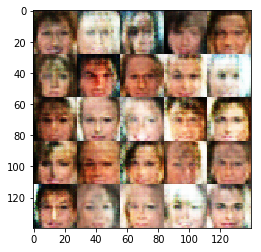

Epoch 1/1 Step 1410... Discriminator Loss: 2.1080... Generator Loss: 3.1258   difference (D-G): -1.0179
Epoch 1/1 Step 1420... Discriminator Loss: 1.0506... Generator Loss: 1.1565   difference (D-G): -0.1058
Epoch 1/1 Step 1430... Discriminator Loss: 1.1530... Generator Loss: 0.6167   difference (D-G): 0.5363
Epoch 1/1 Step 1440... Discriminator Loss: 1.7505... Generator Loss: 0.3147   difference (D-G): 1.4358
Epoch 1/1 Step 1450... Discriminator Loss: 0.8161... Generator Loss: 1.5219   difference (D-G): -0.7059
Epoch 1/1 Step 1460... Discriminator Loss: 0.7974... Generator Loss: 1.3828   difference (D-G): -0.5854
Epoch 1/1 Step 1470... Discriminator Loss: 0.9569... Generator Loss: 2.7816   difference (D-G): -1.8247
Epoch 1/1 Step 1480... Discriminator Loss: 0.8811... Generator Loss: 1.0218   difference (D-G): -0.1407
Epoch 1/1 Step 1490... Discriminator Loss: 1.1116... Generator Loss: 0.6856   difference (D-G): 0.4260
Epoch 1/1 Step 1500... Discriminator Loss: 1.2147... Generator Loss

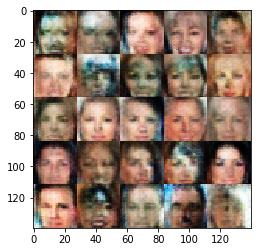

Epoch 1/1 Step 1510... Discriminator Loss: 1.2449... Generator Loss: 0.5801   difference (D-G): 0.6648
Epoch 1/1 Step 1520... Discriminator Loss: 0.8299... Generator Loss: 1.0106   difference (D-G): -0.1807
Epoch 1/1 Step 1530... Discriminator Loss: 1.0618... Generator Loss: 0.7781   difference (D-G): 0.2837
Epoch 1/1 Step 1540... Discriminator Loss: 0.8890... Generator Loss: 1.4457   difference (D-G): -0.5568
Epoch 1/1 Step 1550... Discriminator Loss: 0.9598... Generator Loss: 0.8771   difference (D-G): 0.0827
Epoch 1/1 Step 1560... Discriminator Loss: 0.6743... Generator Loss: 1.6165   difference (D-G): -0.9422
Epoch 1/1 Step 1570... Discriminator Loss: 1.0303... Generator Loss: 1.6709   difference (D-G): -0.6406
Epoch 1/1 Step 1580... Discriminator Loss: 1.0797... Generator Loss: 0.9896   difference (D-G): 0.0901
Epoch 1/1 Step 1590... Discriminator Loss: 1.6313... Generator Loss: 0.4033   difference (D-G): 1.2280
Epoch 1/1 Step 1600... Discriminator Loss: 1.6234... Generator Loss: 

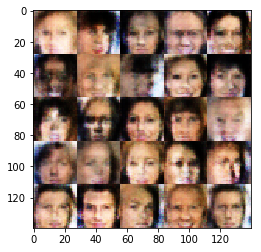

Epoch 1/1 Step 1610... Discriminator Loss: 0.9401... Generator Loss: 1.2091   difference (D-G): -0.2690
Epoch 1/1 Step 1620... Discriminator Loss: 1.5257... Generator Loss: 0.3753   difference (D-G): 1.1505
Epoch 1/1 Step 1630... Discriminator Loss: 1.6719... Generator Loss: 0.3293   difference (D-G): 1.3426
Epoch 1/1 Step 1640... Discriminator Loss: 1.2897... Generator Loss: 0.5311   difference (D-G): 0.7585
Epoch 1/1 Step 1650... Discriminator Loss: 1.1788... Generator Loss: 0.6296   difference (D-G): 0.5491
Epoch 1/1 Step 1660... Discriminator Loss: 0.9674... Generator Loss: 1.0515   difference (D-G): -0.0842
Epoch 1/1 Step 1670... Discriminator Loss: 1.1090... Generator Loss: 0.7758   difference (D-G): 0.3332
Epoch 1/1 Step 1680... Discriminator Loss: 1.0746... Generator Loss: 1.7729   difference (D-G): -0.6983
Epoch 1/1 Step 1690... Discriminator Loss: 0.9870... Generator Loss: 1.7443   difference (D-G): -0.7573
Epoch 1/1 Step 1700... Discriminator Loss: 1.6366... Generator Loss: 

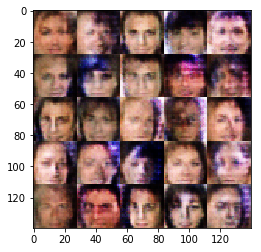

Epoch 1/1 Step 1710... Discriminator Loss: 0.8662... Generator Loss: 1.1776   difference (D-G): -0.3114
Epoch 1/1 Step 1720... Discriminator Loss: 1.9724... Generator Loss: 0.2352   difference (D-G): 1.7372
Epoch 1/1 Step 1730... Discriminator Loss: 0.9576... Generator Loss: 1.0937   difference (D-G): -0.1362
Epoch 1/1 Step 1740... Discriminator Loss: 0.9442... Generator Loss: 0.8135   difference (D-G): 0.1307
Epoch 1/1 Step 1750... Discriminator Loss: 1.2888... Generator Loss: 0.5148   difference (D-G): 0.7741
Epoch 1/1 Step 1760... Discriminator Loss: 1.8654... Generator Loss: 0.2567   difference (D-G): 1.6087
Epoch 1/1 Step 1770... Discriminator Loss: 0.8599... Generator Loss: 1.8016   difference (D-G): -0.9417
Epoch 1/1 Step 1780... Discriminator Loss: 0.8954... Generator Loss: 1.1328   difference (D-G): -0.2374
Epoch 1/1 Step 1790... Discriminator Loss: 1.3155... Generator Loss: 0.5366   difference (D-G): 0.7788
Epoch 1/1 Step 1800... Discriminator Loss: 1.1815... Generator Loss: 

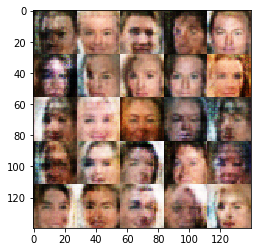

Epoch 1/1 Step 1810... Discriminator Loss: 1.1648... Generator Loss: 2.1358   difference (D-G): -0.9710
Epoch 1/1 Step 1820... Discriminator Loss: 1.8593... Generator Loss: 0.2548   difference (D-G): 1.6044
Epoch 1/1 Step 1830... Discriminator Loss: 1.0765... Generator Loss: 0.7023   difference (D-G): 0.3742
Epoch 1/1 Step 1840... Discriminator Loss: 1.1284... Generator Loss: 0.9499   difference (D-G): 0.1785
Epoch 1/1 Step 1850... Discriminator Loss: 1.1384... Generator Loss: 1.9461   difference (D-G): -0.8077
Epoch 1/1 Step 1860... Discriminator Loss: 1.1607... Generator Loss: 0.6925   difference (D-G): 0.4682
Epoch 1/1 Step 1870... Discriminator Loss: 1.3169... Generator Loss: 0.5500   difference (D-G): 0.7669
Epoch 1/1 Step 1880... Discriminator Loss: 0.8688... Generator Loss: 1.0225   difference (D-G): -0.1537
Epoch 1/1 Step 1890... Discriminator Loss: 0.7076... Generator Loss: 1.5408   difference (D-G): -0.8332
Epoch 1/1 Step 1900... Discriminator Loss: 0.6895... Generator Loss: 

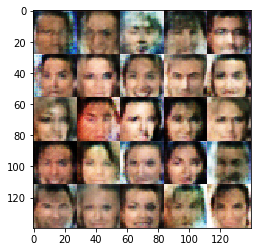

Epoch 1/1 Step 1910... Discriminator Loss: 0.8217... Generator Loss: 1.6600   difference (D-G): -0.8383
Epoch 1/1 Step 1920... Discriminator Loss: 0.9180... Generator Loss: 1.4183   difference (D-G): -0.5004
Epoch 1/1 Step 1930... Discriminator Loss: 1.1397... Generator Loss: 0.7266   difference (D-G): 0.4130
Epoch 1/1 Step 1940... Discriminator Loss: 1.0576... Generator Loss: 1.1408   difference (D-G): -0.0831
Epoch 1/1 Step 1950... Discriminator Loss: 1.1161... Generator Loss: 0.6922   difference (D-G): 0.4239
Epoch 1/1 Step 1960... Discriminator Loss: 1.9967... Generator Loss: 0.2223   difference (D-G): 1.7744
Epoch 1/1 Step 1970... Discriminator Loss: 1.4494... Generator Loss: 0.4545   difference (D-G): 0.9949
Epoch 1/1 Step 1980... Discriminator Loss: 1.7946... Generator Loss: 0.2927   difference (D-G): 1.5019
Epoch 1/1 Step 1990... Discriminator Loss: 1.1093... Generator Loss: 1.6876   difference (D-G): -0.5782
Epoch 1/1 Step 2000... Discriminator Loss: 1.0439... Generator Loss: 

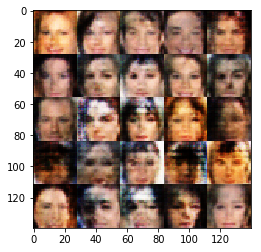

Epoch 1/1 Step 2010... Discriminator Loss: 1.0095... Generator Loss: 0.9053   difference (D-G): 0.1041
Epoch 1/1 Step 2020... Discriminator Loss: 0.8391... Generator Loss: 1.1642   difference (D-G): -0.3251
Epoch 1/1 Step 2030... Discriminator Loss: 1.0257... Generator Loss: 1.7858   difference (D-G): -0.7601
Epoch 1/1 Step 2040... Discriminator Loss: 0.9595... Generator Loss: 1.6875   difference (D-G): -0.7280
Epoch 1/1 Step 2050... Discriminator Loss: 1.1009... Generator Loss: 0.7276   difference (D-G): 0.3733
Epoch 1/1 Step 2060... Discriminator Loss: 1.2695... Generator Loss: 0.6552   difference (D-G): 0.6143
Epoch 1/1 Step 2070... Discriminator Loss: 0.6172... Generator Loss: 2.1708   difference (D-G): -1.5535
Epoch 1/1 Step 2080... Discriminator Loss: 0.7213... Generator Loss: 1.2123   difference (D-G): -0.4910
Epoch 1/1 Step 2090... Discriminator Loss: 1.4133... Generator Loss: 0.4467   difference (D-G): 0.9666
Epoch 1/1 Step 2100... Discriminator Loss: 0.8967... Generator Loss:

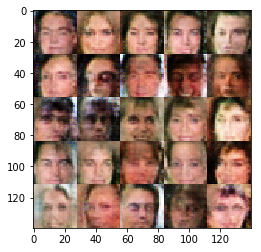

Epoch 1/1 Step 2110... Discriminator Loss: 1.2261... Generator Loss: 3.0938   difference (D-G): -1.8677
Epoch 1/1 Step 2120... Discriminator Loss: 1.0393... Generator Loss: 0.7432   difference (D-G): 0.2961
Epoch 1/1 Step 2130... Discriminator Loss: 1.1161... Generator Loss: 0.7224   difference (D-G): 0.3937
Epoch 1/1 Step 2140... Discriminator Loss: 0.8775... Generator Loss: 1.3542   difference (D-G): -0.4767
Epoch 1/1 Step 2150... Discriminator Loss: 0.8380... Generator Loss: 1.3291   difference (D-G): -0.4911
Epoch 1/1 Step 2160... Discriminator Loss: 1.6089... Generator Loss: 0.3745   difference (D-G): 1.2344
Epoch 1/1 Step 2170... Discriminator Loss: 1.5466... Generator Loss: 0.3745   difference (D-G): 1.1721
Epoch 1/1 Step 2180... Discriminator Loss: 1.4629... Generator Loss: 0.4135   difference (D-G): 1.0494
Epoch 1/1 Step 2190... Discriminator Loss: 0.7895... Generator Loss: 1.2889   difference (D-G): -0.4994
Epoch 1/1 Step 2200... Discriminator Loss: 1.1056... Generator Loss: 

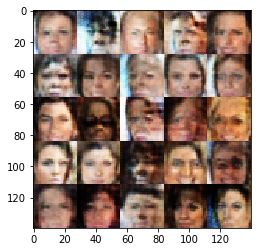

Epoch 1/1 Step 2210... Discriminator Loss: 1.0935... Generator Loss: 0.6626   difference (D-G): 0.4308
Epoch 1/1 Step 2220... Discriminator Loss: 0.9677... Generator Loss: 0.8578   difference (D-G): 0.1098
Epoch 1/1 Step 2230... Discriminator Loss: 0.8442... Generator Loss: 1.0829   difference (D-G): -0.2387
Epoch 1/1 Step 2240... Discriminator Loss: 0.8000... Generator Loss: 1.3370   difference (D-G): -0.5370
Epoch 1/1 Step 2250... Discriminator Loss: 1.2529... Generator Loss: 0.5693   difference (D-G): 0.6836
Epoch 1/1 Step 2260... Discriminator Loss: 0.9291... Generator Loss: 1.0729   difference (D-G): -0.1438
Epoch 1/1 Step 2270... Discriminator Loss: 0.7802... Generator Loss: 2.3244   difference (D-G): -1.5442
Epoch 1/1 Step 2280... Discriminator Loss: 0.7531... Generator Loss: 1.6203   difference (D-G): -0.8672
Epoch 1/1 Step 2290... Discriminator Loss: 0.7450... Generator Loss: 1.1932   difference (D-G): -0.4482
Epoch 1/1 Step 2300... Discriminator Loss: 1.2777... Generator Loss

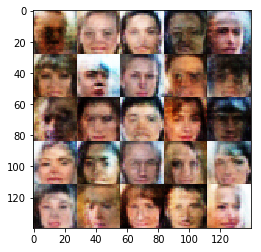

Epoch 1/1 Step 2310... Discriminator Loss: 0.6506... Generator Loss: 1.7487   difference (D-G): -1.0981
Epoch 1/1 Step 2320... Discriminator Loss: 1.6812... Generator Loss: 0.3597   difference (D-G): 1.3215
Epoch 1/1 Step 2330... Discriminator Loss: 0.8815... Generator Loss: 1.1937   difference (D-G): -0.3122
Epoch 1/1 Step 2340... Discriminator Loss: 1.4430... Generator Loss: 0.4113   difference (D-G): 1.0317
Epoch 1/1 Step 2350... Discriminator Loss: 1.7527... Generator Loss: 0.3038   difference (D-G): 1.4489
Epoch 1/1 Step 2360... Discriminator Loss: 1.1148... Generator Loss: 0.6760   difference (D-G): 0.4388
Epoch 1/1 Step 2370... Discriminator Loss: 1.0725... Generator Loss: 0.6935   difference (D-G): 0.3790
Epoch 1/1 Step 2380... Discriminator Loss: 0.7661... Generator Loss: 1.3854   difference (D-G): -0.6194
Epoch 1/1 Step 2390... Discriminator Loss: 0.8684... Generator Loss: 1.1840   difference (D-G): -0.3155
Epoch 1/1 Step 2400... Discriminator Loss: 1.4586... Generator Loss: 

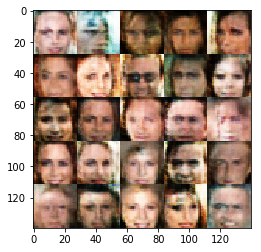

Epoch 1/1 Step 2410... Discriminator Loss: 0.9077... Generator Loss: 0.9385   difference (D-G): -0.0308
Epoch 1/1 Step 2420... Discriminator Loss: 0.7326... Generator Loss: 1.5892   difference (D-G): -0.8566
Epoch 1/1 Step 2430... Discriminator Loss: 1.1558... Generator Loss: 0.8353   difference (D-G): 0.3205
Epoch 1/1 Step 2440... Discriminator Loss: 1.1519... Generator Loss: 0.6557   difference (D-G): 0.4962
Epoch 1/1 Step 2450... Discriminator Loss: 0.7095... Generator Loss: 2.0817   difference (D-G): -1.3722
Epoch 1/1 Step 2460... Discriminator Loss: 0.9323... Generator Loss: 1.2067   difference (D-G): -0.2743
Epoch 1/1 Step 2470... Discriminator Loss: 0.9930... Generator Loss: 0.9166   difference (D-G): 0.0764
Epoch 1/1 Step 2480... Discriminator Loss: 0.8381... Generator Loss: 1.3350   difference (D-G): -0.4970
Epoch 1/1 Step 2490... Discriminator Loss: 1.3739... Generator Loss: 0.4420   difference (D-G): 0.9319
Epoch 1/1 Step 2500... Discriminator Loss: 1.0810... Generator Loss:

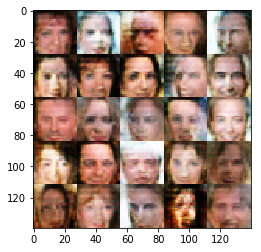

Epoch 1/1 Step 2510... Discriminator Loss: 0.9229... Generator Loss: 1.0963   difference (D-G): -0.1733
Epoch 1/1 Step 2520... Discriminator Loss: 0.9642... Generator Loss: 1.5019   difference (D-G): -0.5377
Epoch 1/1 Step 2530... Discriminator Loss: 1.1244... Generator Loss: 0.7993   difference (D-G): 0.3251
Epoch 1/1 Step 2540... Discriminator Loss: 1.1349... Generator Loss: 0.6724   difference (D-G): 0.4624
Epoch 1/1 Step 2550... Discriminator Loss: 0.7750... Generator Loss: 1.6317   difference (D-G): -0.8566
Epoch 1/1 Step 2560... Discriminator Loss: 1.0537... Generator Loss: 0.7402   difference (D-G): 0.3135
Epoch 1/1 Step 2570... Discriminator Loss: 1.9474... Generator Loss: 0.2489   difference (D-G): 1.6986
Epoch 1/1 Step 2580... Discriminator Loss: 1.2613... Generator Loss: 0.6178   difference (D-G): 0.6434
Epoch 1/1 Step 2590... Discriminator Loss: 1.0562... Generator Loss: 0.8446   difference (D-G): 0.2117
Epoch 1/1 Step 2600... Discriminator Loss: 1.3983... Generator Loss: 0

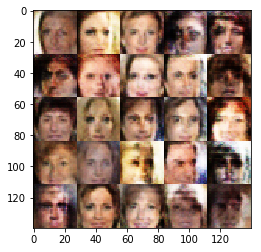

Epoch 1/1 Step 2610... Discriminator Loss: 1.1578... Generator Loss: 0.6650   difference (D-G): 0.4928
Epoch 1/1 Step 2620... Discriminator Loss: 0.8787... Generator Loss: 1.0548   difference (D-G): -0.1760
Epoch 1/1 Step 2630... Discriminator Loss: 0.9679... Generator Loss: 1.1550   difference (D-G): -0.1870
Epoch 1/1 Step 2640... Discriminator Loss: 0.7373... Generator Loss: 1.8245   difference (D-G): -1.0872
Epoch 1/1 Step 2650... Discriminator Loss: 1.1502... Generator Loss: 0.8389   difference (D-G): 0.3113
Epoch 1/1 Step 2660... Discriminator Loss: 1.1667... Generator Loss: 0.7006   difference (D-G): 0.4661
Epoch 1/1 Step 2670... Discriminator Loss: 1.0208... Generator Loss: 0.7885   difference (D-G): 0.2323
Epoch 1/1 Step 2680... Discriminator Loss: 1.1365... Generator Loss: 0.7141   difference (D-G): 0.4224
Epoch 1/1 Step 2690... Discriminator Loss: 0.9593... Generator Loss: 0.8550   difference (D-G): 0.1043
Epoch 1/1 Step 2700... Discriminator Loss: 1.4570... Generator Loss: 0

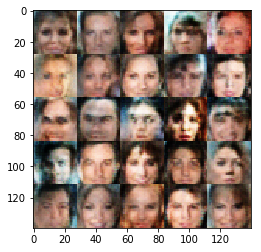

Epoch 1/1 Step 2710... Discriminator Loss: 0.9685... Generator Loss: 0.9642   difference (D-G): 0.0043
Epoch 1/1 Step 2720... Discriminator Loss: 0.8892... Generator Loss: 1.2225   difference (D-G): -0.3332
Epoch 1/1 Step 2730... Discriminator Loss: 1.4441... Generator Loss: 0.4378   difference (D-G): 1.0063
Epoch 1/1 Step 2740... Discriminator Loss: 1.5890... Generator Loss: 2.4639   difference (D-G): -0.8750
Epoch 1/1 Step 2750... Discriminator Loss: 1.3188... Generator Loss: 0.5172   difference (D-G): 0.8016
Epoch 1/1 Step 2760... Discriminator Loss: 1.2852... Generator Loss: 0.5106   difference (D-G): 0.7746
Epoch 1/1 Step 2770... Discriminator Loss: 0.7869... Generator Loss: 1.4175   difference (D-G): -0.6306
Epoch 1/1 Step 2780... Discriminator Loss: 1.2402... Generator Loss: 0.5991   difference (D-G): 0.6411
Epoch 1/1 Step 2790... Discriminator Loss: 1.4213... Generator Loss: 0.4239   difference (D-G): 0.9974
Epoch 1/1 Step 2800... Discriminator Loss: 0.8723... Generator Loss: 2

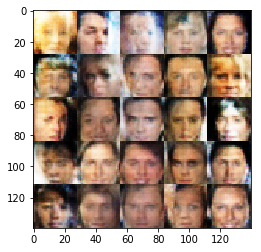

Epoch 1/1 Step 2810... Discriminator Loss: 0.9811... Generator Loss: 0.8116   difference (D-G): 0.1695
Epoch 1/1 Step 2820... Discriminator Loss: 1.2476... Generator Loss: 0.5559   difference (D-G): 0.6917
Epoch 1/1 Step 2830... Discriminator Loss: 0.9503... Generator Loss: 1.4670   difference (D-G): -0.5167
Epoch 1/1 Step 2840... Discriminator Loss: 0.6569... Generator Loss: 1.4691   difference (D-G): -0.8122
Epoch 1/1 Step 2850... Discriminator Loss: 0.8485... Generator Loss: 1.3063   difference (D-G): -0.4578
Epoch 1/1 Step 2860... Discriminator Loss: 0.8684... Generator Loss: 0.9325   difference (D-G): -0.0642
Epoch 1/1 Step 2870... Discriminator Loss: 1.5013... Generator Loss: 2.5522   difference (D-G): -1.0510
Epoch 1/1 Step 2880... Discriminator Loss: 2.6878... Generator Loss: 0.1487   difference (D-G): 2.5391
Epoch 1/1 Step 2890... Discriminator Loss: 0.8206... Generator Loss: 1.4162   difference (D-G): -0.5956
Epoch 1/1 Step 2900... Discriminator Loss: 1.6142... Generator Loss

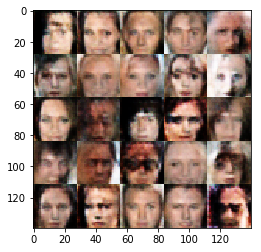

Epoch 1/1 Step 2910... Discriminator Loss: 0.8249... Generator Loss: 1.2533   difference (D-G): -0.4284
Epoch 1/1 Step 2920... Discriminator Loss: 1.7584... Generator Loss: 0.2992   difference (D-G): 1.4593
Epoch 1/1 Step 2930... Discriminator Loss: 0.8725... Generator Loss: 1.1189   difference (D-G): -0.2464
Epoch 1/1 Step 2940... Discriminator Loss: 0.7066... Generator Loss: 1.3052   difference (D-G): -0.5986
Epoch 1/1 Step 2950... Discriminator Loss: 0.8837... Generator Loss: 1.5024   difference (D-G): -0.6187
Epoch 1/1 Step 2960... Discriminator Loss: 0.8369... Generator Loss: 1.1673   difference (D-G): -0.3304
Epoch 1/1 Step 2970... Discriminator Loss: 1.8187... Generator Loss: 0.2801   difference (D-G): 1.5386
Epoch 1/1 Step 2980... Discriminator Loss: 1.1708... Generator Loss: 0.6015   difference (D-G): 0.5693
Epoch 1/1 Step 2990... Discriminator Loss: 1.0436... Generator Loss: 0.9798   difference (D-G): 0.0638
Epoch 1/1 Step 3000... Discriminator Loss: 0.7904... Generator Loss:

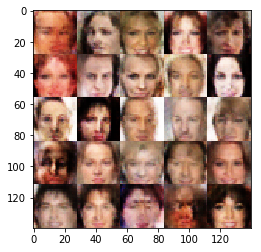

Epoch 1/1 Step 3010... Discriminator Loss: 1.1038... Generator Loss: 0.7602   difference (D-G): 0.3436
Epoch 1/1 Step 3020... Discriminator Loss: 1.6858... Generator Loss: 0.3533   difference (D-G): 1.3325
Epoch 1/1 Step 3030... Discriminator Loss: 3.2961... Generator Loss: 0.0644   difference (D-G): 3.2317
Epoch 1/1 Step 3040... Discriminator Loss: 1.3546... Generator Loss: 0.5448   difference (D-G): 0.8098
Epoch 1/1 Step 3050... Discriminator Loss: 0.9563... Generator Loss: 0.8758   difference (D-G): 0.0805
Epoch 1/1 Step 3060... Discriminator Loss: 1.4272... Generator Loss: 0.4474   difference (D-G): 0.9798
Epoch 1/1 Step 3070... Discriminator Loss: 0.8370... Generator Loss: 1.7135   difference (D-G): -0.8765
Epoch 1/1 Step 3080... Discriminator Loss: 1.9120... Generator Loss: 0.2556   difference (D-G): 1.6563
Epoch 1/1 Step 3090... Discriminator Loss: 1.1933... Generator Loss: 1.6039   difference (D-G): -0.4106
Epoch 1/1 Step 3100... Discriminator Loss: 1.4778... Generator Loss: 0.

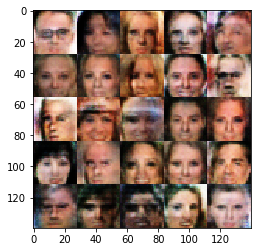

Epoch 1/1 Step 3110... Discriminator Loss: 1.1439... Generator Loss: 2.4531   difference (D-G): -1.3092
Epoch 1/1 Step 3120... Discriminator Loss: 1.8019... Generator Loss: 0.2769   difference (D-G): 1.5251
Epoch 1/1 Step 3130... Discriminator Loss: 1.7523... Generator Loss: 0.3022   difference (D-G): 1.4501
Epoch 1/1 Step 3140... Discriminator Loss: 2.4118... Generator Loss: 0.1571   difference (D-G): 2.2546
Epoch 1/1 Step 3150... Discriminator Loss: 1.2315... Generator Loss: 0.5931   difference (D-G): 0.6384
Epoch 1/1 Step 3160... Discriminator Loss: 1.8060... Generator Loss: 0.3373   difference (D-G): 1.4687
Epoch 1/1 Step 3170... Discriminator Loss: 1.3916... Generator Loss: 0.4510   difference (D-G): 0.9407
Epoch 1/1 Step 3180... Discriminator Loss: 1.2577... Generator Loss: 0.5426   difference (D-G): 0.7151
Epoch 1/1 Step 3190... Discriminator Loss: 0.6716... Generator Loss: 1.4861   difference (D-G): -0.8145
Epoch 1/1 Step 3200... Discriminator Loss: 1.3293... Generator Loss: 0.

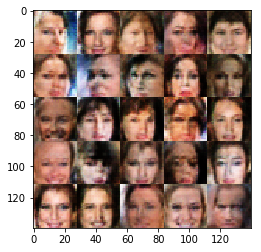

Epoch 1/1 Step 3210... Discriminator Loss: 0.7157... Generator Loss: 1.4185   difference (D-G): -0.7028
Epoch 1/1 Step 3220... Discriminator Loss: 1.0720... Generator Loss: 2.6714   difference (D-G): -1.5994
Epoch 1/1 Step 3230... Discriminator Loss: 0.5666... Generator Loss: 1.7903   difference (D-G): -1.2237
Epoch 1/1 Step 3240... Discriminator Loss: 1.7620... Generator Loss: 0.3058   difference (D-G): 1.4562
Epoch 1/1 Step 3250... Discriminator Loss: 1.1130... Generator Loss: 0.6668   difference (D-G): 0.4461
Epoch 1/1 Step 3260... Discriminator Loss: 0.9151... Generator Loss: 3.5401   difference (D-G): -2.6250
Epoch 1/1 Step 3270... Discriminator Loss: 1.6950... Generator Loss: 0.3302   difference (D-G): 1.3649
Epoch 1/1 Step 3280... Discriminator Loss: 0.9833... Generator Loss: 1.7529   difference (D-G): -0.7696
Epoch 1/1 Step 3290... Discriminator Loss: 0.9542... Generator Loss: 0.9554   difference (D-G): -0.0012
Epoch 1/1 Step 3300... Discriminator Loss: 0.7057... Generator Loss

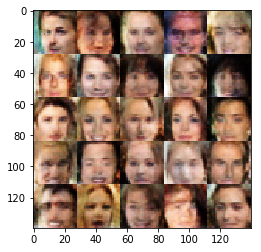

Epoch 1/1 Step 3310... Discriminator Loss: 1.1721... Generator Loss: 1.9442   difference (D-G): -0.7722
Epoch 1/1 Step 3320... Discriminator Loss: 1.3907... Generator Loss: 0.4692   difference (D-G): 0.9215
Epoch 1/1 Step 3330... Discriminator Loss: 1.0488... Generator Loss: 0.7718   difference (D-G): 0.2769
Epoch 1/1 Step 3340... Discriminator Loss: 0.7472... Generator Loss: 2.5897   difference (D-G): -1.8425
Epoch 1/1 Step 3350... Discriminator Loss: 0.8750... Generator Loss: 1.6259   difference (D-G): -0.7509
Epoch 1/1 Step 3360... Discriminator Loss: 1.3294... Generator Loss: 0.5004   difference (D-G): 0.8290
Epoch 1/1 Step 3370... Discriminator Loss: 1.1938... Generator Loss: 0.6053   difference (D-G): 0.5885
Epoch 1/1 Step 3380... Discriminator Loss: 1.4261... Generator Loss: 2.4497   difference (D-G): -1.0236
Epoch 1/1 Step 3390... Discriminator Loss: 1.3479... Generator Loss: 0.4685   difference (D-G): 0.8794
Epoch 1/1 Step 3400... Discriminator Loss: 0.9940... Generator Loss: 

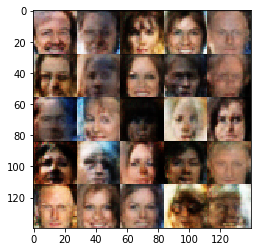

Epoch 1/1 Step 3410... Discriminator Loss: 0.8204... Generator Loss: 1.7408   difference (D-G): -0.9203
Epoch 1/1 Step 3420... Discriminator Loss: 2.3165... Generator Loss: 0.1882   difference (D-G): 2.1284
Epoch 1/1 Step 3430... Discriminator Loss: 0.7909... Generator Loss: 1.1328   difference (D-G): -0.3419
Epoch 1/1 Step 3440... Discriminator Loss: 1.3325... Generator Loss: 0.5375   difference (D-G): 0.7950
Epoch 1/1 Step 3450... Discriminator Loss: 0.9760... Generator Loss: 0.8723   difference (D-G): 0.1037
Epoch 1/1 Step 3460... Discriminator Loss: 1.6942... Generator Loss: 0.3788   difference (D-G): 1.3154
Epoch 1/1 Step 3470... Discriminator Loss: 1.0014... Generator Loss: 3.3366   difference (D-G): -2.3352
Epoch 1/1 Step 3480... Discriminator Loss: 0.7614... Generator Loss: 1.7532   difference (D-G): -0.9918
Epoch 1/1 Step 3490... Discriminator Loss: 1.6185... Generator Loss: 0.4381   difference (D-G): 1.1804
Epoch 1/1 Step 3500... Discriminator Loss: 1.1137... Generator Loss: 

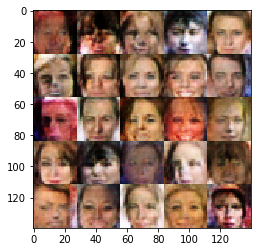

Epoch 1/1 Step 3510... Discriminator Loss: 2.0290... Generator Loss: 0.2321   difference (D-G): 1.7969
Epoch 1/1 Step 3520... Discriminator Loss: 0.9201... Generator Loss: 0.9713   difference (D-G): -0.0512
Epoch 1/1 Step 3530... Discriminator Loss: 1.4241... Generator Loss: 0.4627   difference (D-G): 0.9615
Epoch 1/1 Step 3540... Discriminator Loss: 1.3669... Generator Loss: 0.4817   difference (D-G): 0.8852
Epoch 1/1 Step 3550... Discriminator Loss: 0.9070... Generator Loss: 2.2062   difference (D-G): -1.2993
Epoch 1/1 Step 3560... Discriminator Loss: 2.2561... Generator Loss: 0.1775   difference (D-G): 2.0786
Epoch 1/1 Step 3570... Discriminator Loss: 1.1027... Generator Loss: 2.6340   difference (D-G): -1.5314
Epoch 1/1 Step 3580... Discriminator Loss: 0.7453... Generator Loss: 1.4564   difference (D-G): -0.7111
Epoch 1/1 Step 3590... Discriminator Loss: 1.0127... Generator Loss: 0.7947   difference (D-G): 0.2180
Epoch 1/1 Step 3600... Discriminator Loss: 1.2245... Generator Loss: 

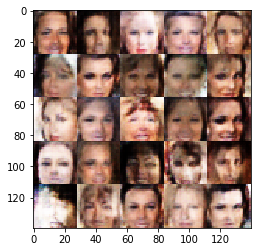

Epoch 1/1 Step 3610... Discriminator Loss: 1.2716... Generator Loss: 0.5331   difference (D-G): 0.7385
Epoch 1/1 Step 3620... Discriminator Loss: 1.3478... Generator Loss: 0.5947   difference (D-G): 0.7531
Epoch 1/1 Step 3630... Discriminator Loss: 1.5495... Generator Loss: 0.3719   difference (D-G): 1.1777
Epoch 1/1 Step 3640... Discriminator Loss: 0.8476... Generator Loss: 1.3036   difference (D-G): -0.4560
Epoch 1/1 Step 3650... Discriminator Loss: 1.4698... Generator Loss: 0.4318   difference (D-G): 1.0380
Epoch 1/1 Step 3660... Discriminator Loss: 1.0777... Generator Loss: 1.4483   difference (D-G): -0.3706
Epoch 1/1 Step 3670... Discriminator Loss: 1.0845... Generator Loss: 0.7201   difference (D-G): 0.3644
Epoch 1/1 Step 3680... Discriminator Loss: 1.8055... Generator Loss: 0.3166   difference (D-G): 1.4889
Epoch 1/1 Step 3690... Discriminator Loss: 1.0714... Generator Loss: 0.7114   difference (D-G): 0.3601
Epoch 1/1 Step 3700... Discriminator Loss: 0.9591... Generator Loss: 1.

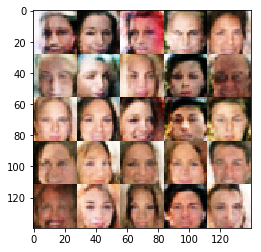

Epoch 1/1 Step 3710... Discriminator Loss: 0.9440... Generator Loss: 0.9064   difference (D-G): 0.0376
Epoch 1/1 Step 3720... Discriminator Loss: 0.8737... Generator Loss: 1.2596   difference (D-G): -0.3858
Epoch 1/1 Step 3730... Discriminator Loss: 0.9500... Generator Loss: 0.8202   difference (D-G): 0.1298
Epoch 1/1 Step 3740... Discriminator Loss: 1.2682... Generator Loss: 0.6542   difference (D-G): 0.6140
Epoch 1/1 Step 3750... Discriminator Loss: 1.5742... Generator Loss: 0.4327   difference (D-G): 1.1415
Epoch 1/1 Step 3760... Discriminator Loss: 0.7094... Generator Loss: 1.5977   difference (D-G): -0.8883
Epoch 1/1 Step 3770... Discriminator Loss: 1.0878... Generator Loss: 2.6025   difference (D-G): -1.5147
Epoch 1/1 Step 3780... Discriminator Loss: 1.7417... Generator Loss: 0.2962   difference (D-G): 1.4455
Epoch 1/1 Step 3790... Discriminator Loss: 1.2638... Generator Loss: 0.5200   difference (D-G): 0.7438
Epoch 1/1 Step 3800... Discriminator Loss: 0.6271... Generator Loss: 1

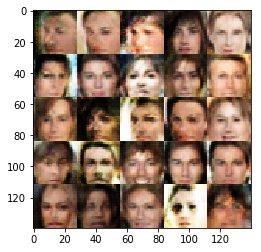

Epoch 1/1 Step 3810... Discriminator Loss: 1.3354... Generator Loss: 0.4908   difference (D-G): 0.8446
Epoch 1/1 Step 3820... Discriminator Loss: 1.6044... Generator Loss: 0.3529   difference (D-G): 1.2515
Epoch 1/1 Step 3830... Discriminator Loss: 0.6678... Generator Loss: 1.8769   difference (D-G): -1.2091
Epoch 1/1 Step 3840... Discriminator Loss: 0.6822... Generator Loss: 1.3058   difference (D-G): -0.6236
Epoch 1/1 Step 3850... Discriminator Loss: 1.2466... Generator Loss: 0.5477   difference (D-G): 0.6988
Epoch 1/1 Step 3860... Discriminator Loss: 0.9076... Generator Loss: 0.9570   difference (D-G): -0.0494
Epoch 1/1 Step 3870... Discriminator Loss: 0.8327... Generator Loss: 1.4622   difference (D-G): -0.6295
Epoch 1/1 Step 3880... Discriminator Loss: 0.6013... Generator Loss: 1.6537   difference (D-G): -1.0524
Epoch 1/1 Step 3890... Discriminator Loss: 1.7164... Generator Loss: 0.3632   difference (D-G): 1.3532
Epoch 1/1 Step 3900... Discriminator Loss: 1.3097... Generator Loss:

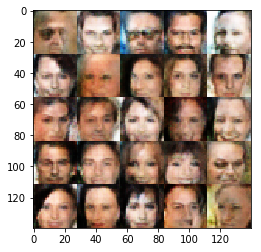

Epoch 1/1 Step 3910... Discriminator Loss: 1.0206... Generator Loss: 0.9685   difference (D-G): 0.0520
Epoch 1/1 Step 3920... Discriminator Loss: 0.6793... Generator Loss: 2.2056   difference (D-G): -1.5263
Epoch 1/1 Step 3930... Discriminator Loss: 0.7704... Generator Loss: 2.2900   difference (D-G): -1.5196
Epoch 1/1 Step 3940... Discriminator Loss: 1.2086... Generator Loss: 0.6148   difference (D-G): 0.5938
Epoch 1/1 Step 3950... Discriminator Loss: 1.1950... Generator Loss: 0.5745   difference (D-G): 0.6205
Epoch 1/1 Step 3960... Discriminator Loss: 1.2719... Generator Loss: 0.5511   difference (D-G): 0.7208
Epoch 1/1 Step 3970... Discriminator Loss: 0.8328... Generator Loss: 1.2846   difference (D-G): -0.4518
Epoch 1/1 Step 3980... Discriminator Loss: 1.2112... Generator Loss: 1.5771   difference (D-G): -0.3659
Epoch 1/1 Step 3990... Discriminator Loss: 1.4323... Generator Loss: 0.4599   difference (D-G): 0.9723
Epoch 1/1 Step 4000... Discriminator Loss: 0.9839... Generator Loss: 

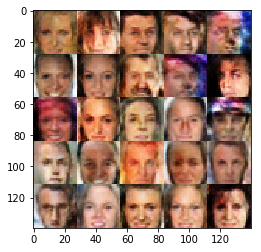

Epoch 1/1 Step 4010... Discriminator Loss: 0.8798... Generator Loss: 0.9558   difference (D-G): -0.0760
Epoch 1/1 Step 4020... Discriminator Loss: 0.7775... Generator Loss: 1.1175   difference (D-G): -0.3400
Epoch 1/1 Step 4030... Discriminator Loss: 1.0627... Generator Loss: 0.7355   difference (D-G): 0.3272
Epoch 1/1 Step 4040... Discriminator Loss: 0.6671... Generator Loss: 1.7927   difference (D-G): -1.1257
Epoch 1/1 Step 4050... Discriminator Loss: 1.0387... Generator Loss: 0.7177   difference (D-G): 0.3210
Epoch 1/1 Step 4060... Discriminator Loss: 1.1546... Generator Loss: 0.6722   difference (D-G): 0.4824
Epoch 1/1 Step 4070... Discriminator Loss: 1.1866... Generator Loss: 0.6942   difference (D-G): 0.4925
Epoch 1/1 Step 4080... Discriminator Loss: 0.9040... Generator Loss: 2.2488   difference (D-G): -1.3448
Epoch 1/1 Step 4090... Discriminator Loss: 1.3008... Generator Loss: 2.5961   difference (D-G): -1.2953
Epoch 1/1 Step 4100... Discriminator Loss: 1.1825... Generator Loss:

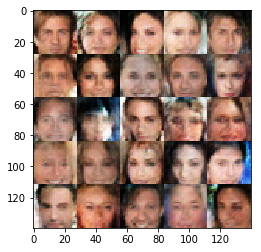

Epoch 1/1 Step 4110... Discriminator Loss: 1.0513... Generator Loss: 0.7309   difference (D-G): 0.3203
Epoch 1/1 Step 4120... Discriminator Loss: 1.0571... Generator Loss: 0.7571   difference (D-G): 0.3000
Epoch 1/1 Step 4130... Discriminator Loss: 2.2009... Generator Loss: 3.0923   difference (D-G): -0.8913
Epoch 1/1 Step 4140... Discriminator Loss: 1.2309... Generator Loss: 0.7144   difference (D-G): 0.5165
Epoch 1/1 Step 4150... Discriminator Loss: 1.6759... Generator Loss: 0.3602   difference (D-G): 1.3157
Epoch 1/1 Step 4160... Discriminator Loss: 2.0960... Generator Loss: 0.1908   difference (D-G): 1.9052
Epoch 1/1 Step 4170... Discriminator Loss: 0.6211... Generator Loss: 1.6665   difference (D-G): -1.0454
Epoch 1/1 Step 4180... Discriminator Loss: 1.2339... Generator Loss: 0.5606   difference (D-G): 0.6734
Epoch 1/1 Step 4190... Discriminator Loss: 0.9958... Generator Loss: 1.2450   difference (D-G): -0.2491
Epoch 1/1 Step 4200... Discriminator Loss: 2.4922... Generator Loss: 0

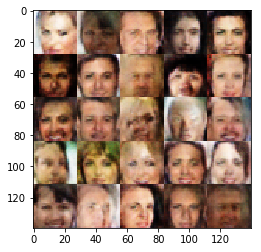

Epoch 1/1 Step 4210... Discriminator Loss: 0.8176... Generator Loss: 1.5386   difference (D-G): -0.7210
Epoch 1/1 Step 4220... Discriminator Loss: 1.0987... Generator Loss: 0.8531   difference (D-G): 0.2456
Epoch 1/1 Step 4230... Discriminator Loss: 1.4542... Generator Loss: 0.4624   difference (D-G): 0.9917
Epoch 1/1 Step 4240... Discriminator Loss: 0.7912... Generator Loss: 1.1712   difference (D-G): -0.3800
Epoch 1/1 Step 4250... Discriminator Loss: 0.9842... Generator Loss: 1.7840   difference (D-G): -0.7998
Epoch 1/1 Step 4260... Discriminator Loss: 1.7878... Generator Loss: 0.2775   difference (D-G): 1.5103
Epoch 1/1 Step 4270... Discriminator Loss: 0.9733... Generator Loss: 0.8813   difference (D-G): 0.0920
Epoch 1/1 Step 4280... Discriminator Loss: 0.6156... Generator Loss: 1.7963   difference (D-G): -1.1806
Epoch 1/1 Step 4290... Discriminator Loss: 0.8482... Generator Loss: 1.7798   difference (D-G): -0.9316
Epoch 1/1 Step 4300... Discriminator Loss: 1.1013... Generator Loss:

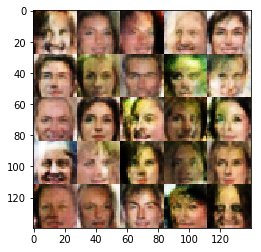

Epoch 1/1 Step 4310... Discriminator Loss: 1.1244... Generator Loss: 1.0761   difference (D-G): 0.0483
Epoch 1/1 Step 4320... Discriminator Loss: 0.6458... Generator Loss: 2.6666   difference (D-G): -2.0208
Epoch 1/1 Step 4330... Discriminator Loss: 0.8842... Generator Loss: 1.0322   difference (D-G): -0.1480
Epoch 1/1 Step 4340... Discriminator Loss: 1.2992... Generator Loss: 0.6863   difference (D-G): 0.6129
Epoch 1/1 Step 4350... Discriminator Loss: 1.0715... Generator Loss: 0.8086   difference (D-G): 0.2629
Epoch 1/1 Step 4360... Discriminator Loss: 0.8434... Generator Loss: 1.3221   difference (D-G): -0.4788
Epoch 1/1 Step 4370... Discriminator Loss: 1.3911... Generator Loss: 0.4561   difference (D-G): 0.9350
Epoch 1/1 Step 4380... Discriminator Loss: 0.8304... Generator Loss: 1.1722   difference (D-G): -0.3418
Epoch 1/1 Step 4390... Discriminator Loss: 0.7432... Generator Loss: 1.5710   difference (D-G): -0.8278
Epoch 1/1 Step 4400... Discriminator Loss: 1.0490... Generator Loss:

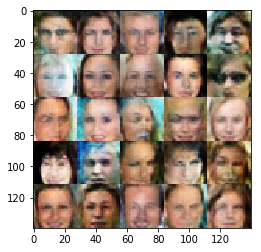

Epoch 1/1 Step 4410... Discriminator Loss: 1.9253... Generator Loss: 3.4409   difference (D-G): -1.5156
Epoch 1/1 Step 4420... Discriminator Loss: 1.0072... Generator Loss: 0.8745   difference (D-G): 0.1327
Epoch 1/1 Step 4430... Discriminator Loss: 1.3595... Generator Loss: 0.4984   difference (D-G): 0.8611
Epoch 1/1 Step 4440... Discriminator Loss: 0.8218... Generator Loss: 1.0189   difference (D-G): -0.1972
Epoch 1/1 Step 4450... Discriminator Loss: 1.5038... Generator Loss: 0.3887   difference (D-G): 1.1151
Epoch 1/1 Step 4460... Discriminator Loss: 0.9814... Generator Loss: 1.3945   difference (D-G): -0.4131
Epoch 1/1 Step 4470... Discriminator Loss: 1.0982... Generator Loss: 0.6653   difference (D-G): 0.4329
Epoch 1/1 Step 4480... Discriminator Loss: 1.5970... Generator Loss: 0.3689   difference (D-G): 1.2281
Epoch 1/1 Step 4490... Discriminator Loss: 0.8639... Generator Loss: 1.6774   difference (D-G): -0.8134
Epoch 1/1 Step 4500... Discriminator Loss: 1.7212... Generator Loss: 

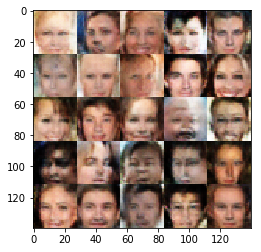

Epoch 1/1 Step 4510... Discriminator Loss: 0.9667... Generator Loss: 0.9164   difference (D-G): 0.0502
Epoch 1/1 Step 4520... Discriminator Loss: 0.9013... Generator Loss: 1.1815   difference (D-G): -0.2803
Epoch 1/1 Step 4530... Discriminator Loss: 2.4740... Generator Loss: 0.1366   difference (D-G): 2.3374
Epoch 1/1 Step 4540... Discriminator Loss: 1.6772... Generator Loss: 0.3314   difference (D-G): 1.3458
Epoch 1/1 Step 4550... Discriminator Loss: 2.6235... Generator Loss: 0.1417   difference (D-G): 2.4818
Epoch 1/1 Step 4560... Discriminator Loss: 0.7925... Generator Loss: 2.1936   difference (D-G): -1.4011
Epoch 1/1 Step 4570... Discriminator Loss: 0.7663... Generator Loss: 1.1549   difference (D-G): -0.3886
Epoch 1/1 Step 4580... Discriminator Loss: 1.2985... Generator Loss: 0.5065   difference (D-G): 0.7920
Epoch 1/1 Step 4590... Discriminator Loss: 1.0977... Generator Loss: 1.2987   difference (D-G): -0.2010
Epoch 1/1 Step 4600... Discriminator Loss: 0.6996... Generator Loss: 

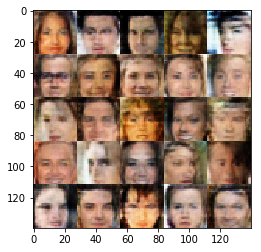

Epoch 1/1 Step 4610... Discriminator Loss: 0.6131... Generator Loss: 2.0597   difference (D-G): -1.4467
Epoch 1/1 Step 4620... Discriminator Loss: 0.9243... Generator Loss: 1.4473   difference (D-G): -0.5230
Epoch 1/1 Step 4630... Discriminator Loss: 0.9455... Generator Loss: 0.8220   difference (D-G): 0.1236
Epoch 1/1 Step 4640... Discriminator Loss: 0.9851... Generator Loss: 0.7909   difference (D-G): 0.1942
Epoch 1/1 Step 4650... Discriminator Loss: 0.8163... Generator Loss: 1.0462   difference (D-G): -0.2299
Epoch 1/1 Step 4660... Discriminator Loss: 1.5247... Generator Loss: 0.4229   difference (D-G): 1.1018
Epoch 1/1 Step 4670... Discriminator Loss: 0.7712... Generator Loss: 2.6177   difference (D-G): -1.8466
Epoch 1/1 Step 4680... Discriminator Loss: 1.0418... Generator Loss: 0.8757   difference (D-G): 0.1660
Epoch 1/1 Step 4690... Discriminator Loss: 1.3125... Generator Loss: 0.5098   difference (D-G): 0.8027
Epoch 1/1 Step 4700... Discriminator Loss: 0.8574... Generator Loss: 

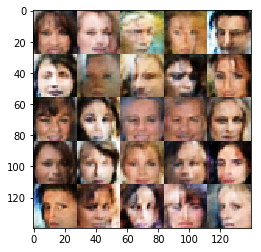

Epoch 1/1 Step 4710... Discriminator Loss: 1.0134... Generator Loss: 0.8889   difference (D-G): 0.1245
Epoch 1/1 Step 4720... Discriminator Loss: 1.1864... Generator Loss: 0.5804   difference (D-G): 0.6060
Epoch 1/1 Step 4730... Discriminator Loss: 1.2211... Generator Loss: 0.9075   difference (D-G): 0.3135
Epoch 1/1 Step 4740... Discriminator Loss: 0.7529... Generator Loss: 1.6552   difference (D-G): -0.9023
Epoch 1/1 Step 4750... Discriminator Loss: 1.2292... Generator Loss: 0.5565   difference (D-G): 0.6727
Epoch 1/1 Step 4760... Discriminator Loss: 1.3523... Generator Loss: 0.4662   difference (D-G): 0.8861
Epoch 1/1 Step 4770... Discriminator Loss: 0.9372... Generator Loss: 1.0996   difference (D-G): -0.1624
Epoch 1/1 Step 4780... Discriminator Loss: 0.9770... Generator Loss: 1.0335   difference (D-G): -0.0566
Epoch 1/1 Step 4790... Discriminator Loss: 1.2401... Generator Loss: 0.5518   difference (D-G): 0.6883
Epoch 1/1 Step 4800... Discriminator Loss: 1.0256... Generator Loss: 0

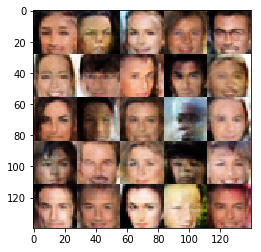

Epoch 1/1 Step 4810... Discriminator Loss: 1.4170... Generator Loss: 0.4507   difference (D-G): 0.9663
Epoch 1/1 Step 4820... Discriminator Loss: 0.9228... Generator Loss: 0.9911   difference (D-G): -0.0683
Epoch 1/1 Step 4830... Discriminator Loss: 1.2367... Generator Loss: 0.5425   difference (D-G): 0.6942
Epoch 1/1 Step 4840... Discriminator Loss: 0.6679... Generator Loss: 2.0652   difference (D-G): -1.3972
Epoch 1/1 Step 4850... Discriminator Loss: 1.2433... Generator Loss: 0.5222   difference (D-G): 0.7211
Epoch 1/1 Step 4860... Discriminator Loss: 0.9455... Generator Loss: 0.8762   difference (D-G): 0.0692
Epoch 1/1 Step 4870... Discriminator Loss: 1.2993... Generator Loss: 0.5845   difference (D-G): 0.7149
Epoch 1/1 Step 4880... Discriminator Loss: 0.8214... Generator Loss: 1.1858   difference (D-G): -0.3644
Epoch 1/1 Step 4890... Discriminator Loss: 0.9680... Generator Loss: 1.0394   difference (D-G): -0.0715
Epoch 1/1 Step 4900... Discriminator Loss: 1.1698... Generator Loss: 

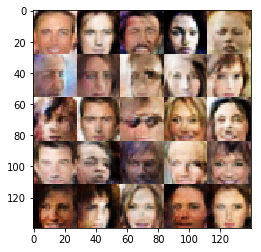

Epoch 1/1 Step 4910... Discriminator Loss: 1.3391... Generator Loss: 0.5440   difference (D-G): 0.7952
Epoch 1/1 Step 4920... Discriminator Loss: 1.1423... Generator Loss: 0.7491   difference (D-G): 0.3932
Epoch 1/1 Step 4930... Discriminator Loss: 1.3472... Generator Loss: 0.5012   difference (D-G): 0.8460
Epoch 1/1 Step 4940... Discriminator Loss: 1.5397... Generator Loss: 0.3676   difference (D-G): 1.1721
Epoch 1/1 Step 4950... Discriminator Loss: 1.2372... Generator Loss: 0.6009   difference (D-G): 0.6363
Epoch 1/1 Step 4960... Discriminator Loss: 1.1065... Generator Loss: 0.7012   difference (D-G): 0.4052
Epoch 1/1 Step 4970... Discriminator Loss: 1.1145... Generator Loss: 0.6968   difference (D-G): 0.4177
Epoch 1/1 Step 4980... Discriminator Loss: 0.9188... Generator Loss: 1.8940   difference (D-G): -0.9752
Epoch 1/1 Step 4990... Discriminator Loss: 0.7752... Generator Loss: 1.4029   difference (D-G): -0.6276
Epoch 1/1 Step 5000... Discriminator Loss: 0.7881... Generator Loss: 1.

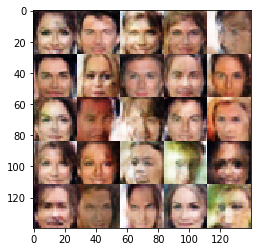

Epoch 1/1 Step 5010... Discriminator Loss: 0.5933... Generator Loss: 1.6816   difference (D-G): -1.0883
Epoch 1/1 Step 5020... Discriminator Loss: 0.7983... Generator Loss: 1.1094   difference (D-G): -0.3111
Epoch 1/1 Step 5030... Discriminator Loss: 1.1084... Generator Loss: 0.6807   difference (D-G): 0.4277
Epoch 1/1 Step 5040... Discriminator Loss: 1.6340... Generator Loss: 0.3652   difference (D-G): 1.2688
Epoch 1/1 Step 5050... Discriminator Loss: 1.4786... Generator Loss: 0.4349   difference (D-G): 1.0438
Epoch 1/1 Step 5060... Discriminator Loss: 1.1764... Generator Loss: 0.6127   difference (D-G): 0.5637
Epoch 1/1 Step 5070... Discriminator Loss: 1.0418... Generator Loss: 0.8207   difference (D-G): 0.2211
Epoch 1/1 Step 5080... Discriminator Loss: 0.7222... Generator Loss: 1.5175   difference (D-G): -0.7953
Epoch 1/1 Step 5090... Discriminator Loss: 0.9756... Generator Loss: 0.8876   difference (D-G): 0.0880
Epoch 1/1 Step 5100... Discriminator Loss: 1.5434... Generator Loss: 0

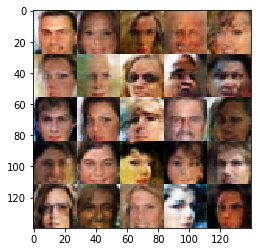

Epoch 1/1 Step 5110... Discriminator Loss: 0.6017... Generator Loss: 2.1901   difference (D-G): -1.5884
Epoch 1/1 Step 5120... Discriminator Loss: 0.7315... Generator Loss: 1.7492   difference (D-G): -1.0177
Epoch 1/1 Step 5130... Discriminator Loss: 1.6380... Generator Loss: 0.3359   difference (D-G): 1.3021
Epoch 1/1 Step 5140... Discriminator Loss: 1.6437... Generator Loss: 0.3613   difference (D-G): 1.2825
Epoch 1/1 Step 5150... Discriminator Loss: 0.8448... Generator Loss: 1.0884   difference (D-G): -0.2435
Epoch 1/1 Step 5160... Discriminator Loss: 0.7071... Generator Loss: 2.2103   difference (D-G): -1.5032
Epoch 1/1 Step 5170... Discriminator Loss: 1.7687... Generator Loss: 0.2967   difference (D-G): 1.4720
Epoch 1/1 Step 5180... Discriminator Loss: 1.3658... Generator Loss: 0.5576   difference (D-G): 0.8082
Epoch 1/1 Step 5190... Discriminator Loss: 1.0006... Generator Loss: 0.8974   difference (D-G): 0.1031
Epoch 1/1 Step 5200... Discriminator Loss: 1.5401... Generator Loss: 

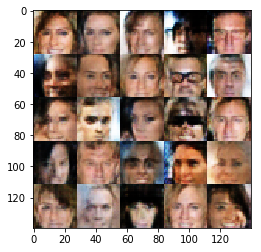

Epoch 1/1 Step 5210... Discriminator Loss: 1.2307... Generator Loss: 0.6647   difference (D-G): 0.5659
Epoch 1/1 Step 5220... Discriminator Loss: 1.0487... Generator Loss: 0.7767   difference (D-G): 0.2721
Epoch 1/1 Step 5230... Discriminator Loss: 0.9454... Generator Loss: 1.0340   difference (D-G): -0.0886
Epoch 1/1 Step 5240... Discriminator Loss: 0.7902... Generator Loss: 1.3165   difference (D-G): -0.5263
Epoch 1/1 Step 5250... Discriminator Loss: 1.0945... Generator Loss: 0.7240   difference (D-G): 0.3705
Epoch 1/1 Step 5260... Discriminator Loss: 0.8809... Generator Loss: 0.8948   difference (D-G): -0.0139
Epoch 1/1 Step 5270... Discriminator Loss: 0.7283... Generator Loss: 1.2380   difference (D-G): -0.5097
Epoch 1/1 Step 5280... Discriminator Loss: 0.7740... Generator Loss: 1.3312   difference (D-G): -0.5572
Epoch 1/1 Step 5290... Discriminator Loss: 1.9001... Generator Loss: 0.2695   difference (D-G): 1.6306
Epoch 1/1 Step 5300... Discriminator Loss: 0.8815... Generator Loss:

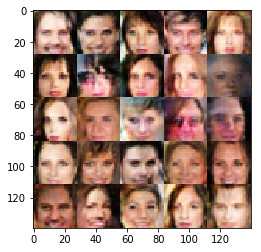

Epoch 1/1 Step 5310... Discriminator Loss: 0.6867... Generator Loss: 1.8579   difference (D-G): -1.1712
Epoch 1/1 Step 5320... Discriminator Loss: 0.9121... Generator Loss: 1.0462   difference (D-G): -0.1341
Epoch 1/1 Step 5330... Discriminator Loss: 2.4579... Generator Loss: 0.1414   difference (D-G): 2.3164
Epoch 1/1 Step 5340... Discriminator Loss: 0.7859... Generator Loss: 1.5217   difference (D-G): -0.7357
Epoch 1/1 Step 5350... Discriminator Loss: 1.7451... Generator Loss: 0.3018   difference (D-G): 1.4433
Epoch 1/1 Step 5360... Discriminator Loss: 0.8829... Generator Loss: 1.7757   difference (D-G): -0.8928
Epoch 1/1 Step 5370... Discriminator Loss: 1.3632... Generator Loss: 0.5315   difference (D-G): 0.8317
Epoch 1/1 Step 5380... Discriminator Loss: 1.5274... Generator Loss: 0.4230   difference (D-G): 1.1044
Epoch 1/1 Step 5390... Discriminator Loss: 1.5925... Generator Loss: 0.3667   difference (D-G): 1.2258
Epoch 1/1 Step 5400... Discriminator Loss: 0.7947... Generator Loss: 

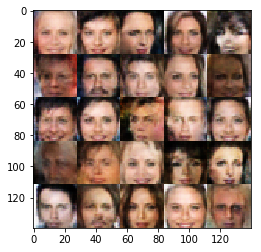

Epoch 1/1 Step 5410... Discriminator Loss: 1.5329... Generator Loss: 0.3892   difference (D-G): 1.1437
Epoch 1/1 Step 5420... Discriminator Loss: 1.1577... Generator Loss: 0.6717   difference (D-G): 0.4859
Epoch 1/1 Step 5430... Discriminator Loss: 0.8547... Generator Loss: 2.2935   difference (D-G): -1.4387
Epoch 1/1 Step 5440... Discriminator Loss: 1.1238... Generator Loss: 1.1777   difference (D-G): -0.0539
Epoch 1/1 Step 5450... Discriminator Loss: 1.7966... Generator Loss: 0.3294   difference (D-G): 1.4673
Epoch 1/1 Step 5460... Discriminator Loss: 0.8675... Generator Loss: 2.0444   difference (D-G): -1.1769
Epoch 1/1 Step 5470... Discriminator Loss: 1.8934... Generator Loss: 0.2523   difference (D-G): 1.6412
Epoch 1/1 Step 5480... Discriminator Loss: 1.4644... Generator Loss: 0.5784   difference (D-G): 0.8859
Epoch 1/1 Step 5490... Discriminator Loss: 1.3539... Generator Loss: 0.5641   difference (D-G): 0.7898
Epoch 1/1 Step 5500... Discriminator Loss: 0.6546... Generator Loss: 1

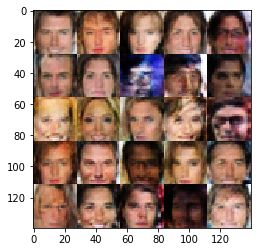

Epoch 1/1 Step 5510... Discriminator Loss: 0.8187... Generator Loss: 1.1882   difference (D-G): -0.3695
Epoch 1/1 Step 5520... Discriminator Loss: 0.7576... Generator Loss: 1.1502   difference (D-G): -0.3926
Epoch 1/1 Step 5530... Discriminator Loss: 0.9953... Generator Loss: 0.7864   difference (D-G): 0.2089
Epoch 1/1 Step 5540... Discriminator Loss: 1.5442... Generator Loss: 0.4028   difference (D-G): 1.1414
Epoch 1/1 Step 5550... Discriminator Loss: 1.6950... Generator Loss: 0.3610   difference (D-G): 1.3340
Epoch 1/1 Step 5560... Discriminator Loss: 1.3599... Generator Loss: 0.5644   difference (D-G): 0.7955
Epoch 1/1 Step 5570... Discriminator Loss: 0.8552... Generator Loss: 1.5564   difference (D-G): -0.7012
Epoch 1/1 Step 5580... Discriminator Loss: 1.0194... Generator Loss: 2.2485   difference (D-G): -1.2291
Epoch 1/1 Step 5590... Discriminator Loss: 0.6865... Generator Loss: 1.3755   difference (D-G): -0.6889
Epoch 1/1 Step 5600... Discriminator Loss: 0.9642... Generator Loss:

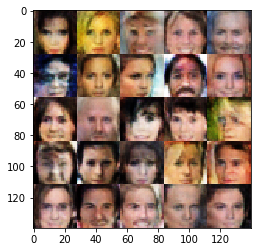

Epoch 1/1 Step 5610... Discriminator Loss: 1.7168... Generator Loss: 4.8367   difference (D-G): -3.1199
Epoch 1/1 Step 5620... Discriminator Loss: 1.0784... Generator Loss: 0.6907   difference (D-G): 0.3877
Epoch 1/1 Step 5630... Discriminator Loss: 1.0233... Generator Loss: 2.1034   difference (D-G): -1.0801
Epoch 1/1 Step 5640... Discriminator Loss: 1.1194... Generator Loss: 0.6898   difference (D-G): 0.4296
Epoch 1/1 Step 5650... Discriminator Loss: 0.6950... Generator Loss: 1.4070   difference (D-G): -0.7120
Epoch 1/1 Step 5660... Discriminator Loss: 0.9316... Generator Loss: 1.3882   difference (D-G): -0.4566
Epoch 1/1 Step 5670... Discriminator Loss: 0.9508... Generator Loss: 0.8557   difference (D-G): 0.0952
Epoch 1/1 Step 5680... Discriminator Loss: 1.2402... Generator Loss: 0.5873   difference (D-G): 0.6529
Epoch 1/1 Step 5690... Discriminator Loss: 1.7251... Generator Loss: 0.3622   difference (D-G): 1.3629
Epoch 1/1 Step 5700... Discriminator Loss: 1.0340... Generator Loss: 

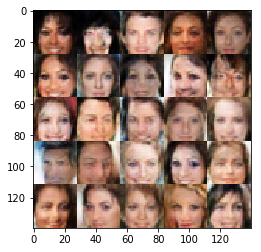

Epoch 1/1 Step 5710... Discriminator Loss: 1.0926... Generator Loss: 0.6697   difference (D-G): 0.4230
Epoch 1/1 Step 5720... Discriminator Loss: 1.2917... Generator Loss: 0.5357   difference (D-G): 0.7560
Epoch 1/1 Step 5730... Discriminator Loss: 1.0216... Generator Loss: 0.7655   difference (D-G): 0.2561
Epoch 1/1 Step 5740... Discriminator Loss: 0.9777... Generator Loss: 0.8628   difference (D-G): 0.1149
Epoch 1/1 Step 5750... Discriminator Loss: 0.7605... Generator Loss: 1.8029   difference (D-G): -1.0424
Epoch 1/1 Step 5760... Discriminator Loss: 1.1158... Generator Loss: 0.7462   difference (D-G): 0.3696
Epoch 1/1 Step 5770... Discriminator Loss: 0.7533... Generator Loss: 1.2785   difference (D-G): -0.5253
Epoch 1/1 Step 5780... Discriminator Loss: 1.0600... Generator Loss: 1.0580   difference (D-G): 0.0020
Epoch 1/1 Step 5790... Discriminator Loss: 1.2058... Generator Loss: 2.6956   difference (D-G): -1.4898
Epoch 1/1 Step 5800... Discriminator Loss: 1.3865... Generator Loss: 0

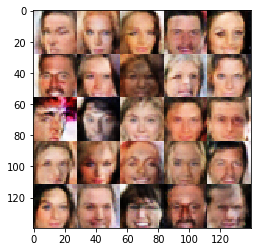

Epoch 1/1 Step 5810... Discriminator Loss: 1.1043... Generator Loss: 2.7711   difference (D-G): -1.6667
Epoch 1/1 Step 5820... Discriminator Loss: 1.0032... Generator Loss: 0.8970   difference (D-G): 0.1062
Epoch 1/1 Step 5830... Discriminator Loss: 0.9813... Generator Loss: 0.7796   difference (D-G): 0.2018
Epoch 1/1 Step 5840... Discriminator Loss: 1.1519... Generator Loss: 0.5987   difference (D-G): 0.5532
Epoch 1/1 Step 5850... Discriminator Loss: 1.2834... Generator Loss: 0.5513   difference (D-G): 0.7321
Epoch 1/1 Step 5860... Discriminator Loss: 1.0581... Generator Loss: 0.7496   difference (D-G): 0.3085
Epoch 1/1 Step 5870... Discriminator Loss: 1.0518... Generator Loss: 0.7549   difference (D-G): 0.2968
Epoch 1/1 Step 5880... Discriminator Loss: 1.4435... Generator Loss: 0.4158   difference (D-G): 1.0278
Epoch 1/1 Step 5890... Discriminator Loss: 0.7818... Generator Loss: 1.1387   difference (D-G): -0.3569
Epoch 1/1 Step 5900... Discriminator Loss: 1.5103... Generator Loss: 0.

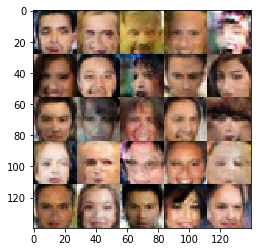

Epoch 1/1 Step 5910... Discriminator Loss: 1.1370... Generator Loss: 0.7353   difference (D-G): 0.4017
Epoch 1/1 Step 5920... Discriminator Loss: 0.8786... Generator Loss: 0.9122   difference (D-G): -0.0336
Epoch 1/1 Step 5930... Discriminator Loss: 1.6955... Generator Loss: 0.3274   difference (D-G): 1.3681
Epoch 1/1 Step 5940... Discriminator Loss: 1.6551... Generator Loss: 0.3277   difference (D-G): 1.3275
Epoch 1/1 Step 5950... Discriminator Loss: 1.0425... Generator Loss: 0.7096   difference (D-G): 0.3329
Epoch 1/1 Step 5960... Discriminator Loss: 0.8134... Generator Loss: 1.1796   difference (D-G): -0.3662
Epoch 1/1 Step 5970... Discriminator Loss: 2.0536... Generator Loss: 0.2242   difference (D-G): 1.8294
Epoch 1/1 Step 5980... Discriminator Loss: 0.8713... Generator Loss: 0.9798   difference (D-G): -0.1084
Epoch 1/1 Step 5990... Discriminator Loss: 1.6029... Generator Loss: 0.3829   difference (D-G): 1.2200
Epoch 1/1 Step 6000... Discriminator Loss: 0.6274... Generator Loss: 1

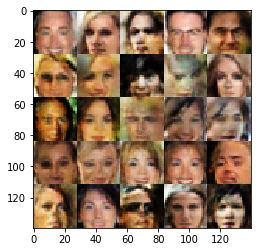

Epoch 1/1 Step 6010... Discriminator Loss: 1.1011... Generator Loss: 2.3987   difference (D-G): -1.2976
Epoch 1/1 Step 6020... Discriminator Loss: 1.2430... Generator Loss: 0.5894   difference (D-G): 0.6536
Epoch 1/1 Step 6030... Discriminator Loss: 1.9140... Generator Loss: 0.2555   difference (D-G): 1.6584
Epoch 1/1 Step 6040... Discriminator Loss: 0.9741... Generator Loss: 1.3879   difference (D-G): -0.4138
Epoch 1/1 Step 6050... Discriminator Loss: 0.7873... Generator Loss: 1.1080   difference (D-G): -0.3208
Epoch 1/1 Step 6060... Discriminator Loss: 0.7782... Generator Loss: 1.8924   difference (D-G): -1.1142
Epoch 1/1 Step 6070... Discriminator Loss: 0.6203... Generator Loss: 1.7784   difference (D-G): -1.1582
Epoch 1/1 Step 6080... Discriminator Loss: 0.9283... Generator Loss: 0.8493   difference (D-G): 0.0790
Epoch 1/1 Step 6090... Discriminator Loss: 0.7820... Generator Loss: 1.4715   difference (D-G): -0.6895
Epoch 1/1 Step 6100... Discriminator Loss: 1.7326... Generator Loss

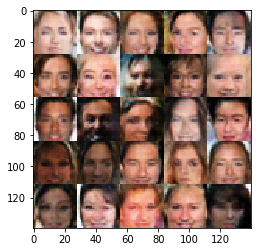

Epoch 1/1 Step 6110... Discriminator Loss: 0.9430... Generator Loss: 2.7162   difference (D-G): -1.7732
Epoch 1/1 Step 6120... Discriminator Loss: 0.8548... Generator Loss: 1.1859   difference (D-G): -0.3311
Epoch 1/1 Step 6130... Discriminator Loss: 0.8205... Generator Loss: 1.6339   difference (D-G): -0.8135
Epoch 1/1 Step 6140... Discriminator Loss: 0.7903... Generator Loss: 1.0405   difference (D-G): -0.2502
Epoch 1/1 Step 6150... Discriminator Loss: 1.2528... Generator Loss: 0.5275   difference (D-G): 0.7253
Epoch 1/1 Step 6160... Discriminator Loss: 2.8171... Generator Loss: 0.1030   difference (D-G): 2.7141
Epoch 1/1 Step 6170... Discriminator Loss: 1.5716... Generator Loss: 0.4177   difference (D-G): 1.1538
Epoch 1/1 Step 6180... Discriminator Loss: 1.1992... Generator Loss: 0.5908   difference (D-G): 0.6084
Epoch 1/1 Step 6190... Discriminator Loss: 1.1197... Generator Loss: 0.6379   difference (D-G): 0.4818
Epoch 1/1 Step 6200... Discriminator Loss: 1.3503... Generator Loss: 

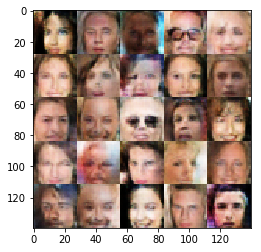

Epoch 1/1 Step 6210... Discriminator Loss: 0.7075... Generator Loss: 2.9288   difference (D-G): -2.2214
Epoch 1/1 Step 6220... Discriminator Loss: 1.2856... Generator Loss: 0.7956   difference (D-G): 0.4899
Epoch 1/1 Step 6230... Discriminator Loss: 1.9956... Generator Loss: 0.2269   difference (D-G): 1.7687
Epoch 1/1 Step 6240... Discriminator Loss: 0.9096... Generator Loss: 0.9340   difference (D-G): -0.0244
Epoch 1/1 Step 6250... Discriminator Loss: 1.3479... Generator Loss: 0.5398   difference (D-G): 0.8081
Epoch 1/1 Step 6260... Discriminator Loss: 0.5591... Generator Loss: 1.6984   difference (D-G): -1.1392
Epoch 1/1 Step 6270... Discriminator Loss: 1.0502... Generator Loss: 1.6690   difference (D-G): -0.6188
Epoch 1/1 Step 6280... Discriminator Loss: 0.6982... Generator Loss: 1.7225   difference (D-G): -1.0243
Epoch 1/1 Step 6290... Discriminator Loss: 0.7515... Generator Loss: 1.4384   difference (D-G): -0.6869
Epoch 1/1 Step 6300... Discriminator Loss: 1.0093... Generator Loss

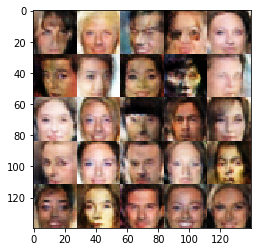

Epoch 1/1 Step 6310... Discriminator Loss: 1.4213... Generator Loss: 3.0514   difference (D-G): -1.6301
Epoch 1/1 Step 6320... Discriminator Loss: 1.1434... Generator Loss: 0.6439   difference (D-G): 0.4995
Epoch 1/1 Step 6330... Discriminator Loss: 1.3432... Generator Loss: 0.5188   difference (D-G): 0.8245


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.